In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
#from keras import metrics
#from keras.datasets import fashion_mnist

from sklearn.metrics import classification_report, confusion_matrix

tf.get_logger().setLevel('INFO')

In [2]:
## Identify tickers for S&P 500 companies from Wikipedia

sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].to_list()
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

In [3]:
## Download closing stock price for a time period

# Download adjusted close prices for S&P 500 tickers
start_date = '2018-01-01'
end_date = '2024-12-01'

data_SP = yf.download(sp500_tickers, start=start_date, end=end_date, group_by="ticker")


[*********************100%***********************]  503 of 503 completed


In [4]:
data_SP

Ticker                            LYV                                      \
Price                            Open        High         Low       Close   
Date                                                                        
2018-01-02 00:00:00+00:00   42.730000   42.799999   42.310001   42.650002   
2018-01-03 00:00:00+00:00   42.840000   42.840000   42.279999   42.509998   
2018-01-04 00:00:00+00:00   42.619999   42.759998   42.130001   42.270000   
2018-01-05 00:00:00+00:00   42.369999   43.400002   42.099998   43.320000   
2018-01-08 00:00:00+00:00   43.240002   43.320000   42.650002   43.049999   
...                               ...         ...         ...         ...   
2024-11-22 00:00:00+00:00  138.419998  140.289993  137.839996  140.289993   
2024-11-25 00:00:00+00:00  140.979996  141.179993  139.089996  140.539993   
2024-11-26 00:00:00+00:00  140.330002  140.649994  137.720001  138.869995   
2024-11-27 00:00:00+00:00  138.800003  140.910004  138.710007  139.729996   
2024-11-29 00:00:00+00:00  139.160004  139.929993  138.100006  138.250000   

Ticker                                                AVGO              \
Price                       Adj Close   Volume        Open        High   
Date                                                                     
2018-01-02 00:00:00+00:00   42.650002   926800   25.976999   26.750000   
2018-01-03 00:00:00+00:00   42.509998  1252400   26.729000   27.073000   
2018-01-04 00:00:00+00:00   42.270000  1265400   27.159000   27.176001   
2018-01-05 00:00:00+00:00   43.320000  1070900   27.197001   27.426001   
2018-01-08 00:00:00+00:00   43.049999   973900   27.091999   27.254999   
...                               ...      ...         ...         ...   
2024-11-22 00:00:00+00:00  140.289993  1679400  164.300003  164.910004   
2024-11-25 00:00:00+00:00  140.539993  3726900  165.399994  167.229996   
2024-11-26 00:00:00+00:00  138.869995  2338100  164.600006  166.369995   
2024-11-27 00:00:00+00:00  139.729996  1551100  163.199997  163.199997   
2024-11-29 00:00:00+00:00  138.250000  1036500  159.570007  162.690002   

Ticker                                             ...    AES         \
Price                             Low       Close  ...    Low  Close   
Date                                               ...                 
2018-01-02 00:00:00+00:00   25.757000   26.701000  ...  10.78  10.88   
2018-01-03 00:00:00+00:00   26.603001   26.993000  ...  10.79  10.87   
2018-01-04 00:00:00+00:00   26.843000   27.002001  ...  10.83  10.83   
2018-01-05 00:00:00+00:00   26.945000   27.162001  ...  10.78  10.87   
2018-01-08 00:00:00+00:00   26.906000   27.226999  ...  10.83  10.87   
...                               ...         ...  ...    ...    ...   
2024-11-22 00:00:00+00:00  162.399994  164.229996  ...  12.97  13.04   
2024-11-25 00:00:00+00:00  162.889999  164.820007  ...  13.05  13.16   
2024-11-26 00:00:00+00:00  162.690002  164.740005  ...  12.53  12.58   
2024-11-27 00:00:00+00:00  157.539993  159.669998  ...  12.65  12.99   
2024-11-29 00:00:00+00:00  159.080002  162.080002  ...  12.96  13.04   

Ticker                                                 AFL              \
Price                      Adj Close    Volume        Open        High   
Date                                                                     
2018-01-02 00:00:00+00:00   8.634366   4564500   44.180000   44.330002   
2018-01-03 00:00:00+00:00   8.626429   6181200   43.865002   44.160000   
2018-01-04 00:00:00+00:00   8.594687   5150000   44.285000   44.919998   
2018-01-05 00:00:00+00:00   8.626429   5388200   44.685001   44.875000   
2018-01-08 00:00:00+00:00   8.626429   6689100   44.935001   45.049999   
...                              ...       ...         ...         ...   
2024-11-22 00:00:00+00:00  13.040000  29753100  112.169998  113.150002   
2024-11-25 00:00:00+00:00  13.160000  17646800  112.760002  113.980003   
2024-11-26 00:00:00+00:00  12.580000  20868700  112.730003  1

In [5]:
# Create a list to store data for each ticker
data_list = []

# Loop through each ticker to extract the adjusted close price only
for ticker in sp500_tickers:
    if ticker in data_SP:
        ticker_data = data_SP[ticker]['Adj Close'].dropna().reset_index()
        ticker_data['Ticker'] = ticker  # Add a column for the ticker symbol
        data_list.append(ticker_data)


In [6]:
data_list

[                          Date   Adj Close Ticker
 0    2018-01-02 00:00:00+00:00  151.698502    MMM
 1    2018-01-03 00:00:00+00:00  151.692047    MMM
 2    2018-01-04 00:00:00+00:00  153.674911    MMM
 3    2018-01-05 00:00:00+00:00  154.872345    MMM
 4    2018-01-08 00:00:00+00:00  154.370178    MMM
 ...                        ...         ...    ...
 1735 2024-11-22 00:00:00+00:00  128.419998    MMM
 1736 2024-11-25 00:00:00+00:00  130.320007    MMM
 1737 2024-11-26 00:00:00+00:00  132.949997    MMM
 1738 2024-11-27 00:00:00+00:00  132.479996    MMM
 1739 2024-11-29 00:00:00+00:00  133.529999    MMM
 
 [1740 rows x 3 columns],
                           Date  Adj Close Ticker
 0    2018-01-02 00:00:00+00:00  54.426792    AOS
 1    2018-01-03 00:00:00+00:00  54.754093    AOS
 2    2018-01-04 00:00:00+00:00  55.010612    AOS
 3    2018-01-05 00:00:00+00:00  55.718254    AOS
 4    2018-01-08 00:00:00+00:00  55.983624    AOS
 ...                        ...        ...    ...
 1735 2024

In [7]:
# Concatenate all ticker data into one dataframe
adj_close_data = pd.concat(data_list)

# Rename columns
adj_close_data.columns = ['Date', 'Adj Close', 'Ticker']

# Ensure 'Date' column is in datetime format so we can later determine Year/Qtr
adj_close_data['Date'] = pd.to_datetime(adj_close_data['Date'], errors='coerce')
adj_close_data.dropna(subset=['Date'], inplace=True)  # Drop rows where Date couldn't be parsed
adj_close_data.set_index('Date', inplace=True)

In [8]:
# Calculate quarterly returns - create list to store returns
quarterly_returns_list = []

# Define the specific date and target quarter
target_date = pd.Timestamp("2024-11-29")
target_quarter = "2024-Q4"

# Process each ticker individually
for ticker in adj_close_data['Ticker'].unique():
    ticker_data = adj_close_data[adj_close_data['Ticker'] == ticker].copy()

    # Ensure the data is sorted by date
    ticker_data = ticker_data.sort_index()

    # Resample data for quarters (all except target quarter)
    ticker_data_quarterly = ticker_data['Adj Close'].resample('Q').ohlc()

    # Add return column for all quarters before the target quarter
    ticker_data_quarterly['Return'] = (ticker_data_quarterly['close'] - ticker_data_quarterly['open']) / ticker_data_quarterly['open']

    # Add metadata for all quarters
    ticker_data_quarterly['Date'] = ticker_data_quarterly.index
    ticker_data_quarterly.index = ticker_data_quarterly.index.tz_localize(None)
    ticker_data_quarterly['Quarter'] = ticker_data_quarterly.index.to_period("Q")
    ticker_data_quarterly['Yr'] = ticker_data_quarterly.index.year
    ticker_data_quarterly['Qtr'] = ticker_data_quarterly.index.quarter
    ticker_data_quarterly['year_qtr'] = ticker_data_quarterly['Quarter'].astype(str)
    ticker_data_quarterly['Ticker'] = ticker

    # Process 2024-Q4 differently
    if target_quarter in ticker_data_quarterly['year_qtr'].values:
        q4_start_date = ticker_data_quarterly[ticker_data_quarterly['year_qtr'] == target_quarter].index.min()
        if not pd.isna(q4_start_date):
            q4_start_price = ticker_data.loc[q4_start_date, 'Adj Close']

            # Ensure the target date exists in the data
            target_date_price = None
            if target_date in ticker_data.index:
                target_date_price = ticker_data.loc[target_date, 'Adj Close']

            # Calculate the return for 2024-Q4
            if target_date_price is not None:
                q4_return = (target_date_price - q4_start_price) / q4_start_price
                # Update 2024-Q4 return
                ticker_data_quarterly.loc[ticker_data_quarterly['year_qtr'] == target_quarter, 'Return'] = q4_return

    # Append relevant columns for this ticker to the results list
    quarterly_returns_list.append(ticker_data_quarterly[['Date', 'Ticker', 'Yr', 'Qtr', 'year_qtr', 'Return']])

# Combine all tickers into a single DataFrame
quarterly_returns_data = pd.concat(quarterly_returns_list)

# Display the quarterly returns DataFrame
print(quarterly_returns_data)

                                Date Ticker    Yr  Qtr year_qtr    Return
Date                                                                     
2018-03-31 2018-03-31 00:00:00+00:00    MMM  2018    1   2018Q1 -0.062916
2018-06-30 2018-06-30 00:00:00+00:00    MMM  2018    2   2018Q2 -0.068453
2018-09-30 2018-09-30 00:00:00+00:00    MMM  2018    3   2018Q3  0.084914
2018-12-31 2018-12-31 00:00:00+00:00    MMM  2018    4   2018Q4 -0.095899
2019-03-31 2019-03-31 00:00:00+00:00    MMM  2019    1   2019Q1  0.095661
...                              ...    ...   ...  ...      ...       ...
2023-12-31 2023-12-31 00:00:00+00:00    ZTS  2023    4   2023Q4  0.145386
2024-03-31 2024-03-31 00:00:00+00:00    ZTS  2024    1   2024Q1 -0.137235
2024-06-30 2024-06-30 00:00:00+00:00    ZTS  2024    2   2024Q2  0.040919
2024-09-30 2024-09-30 00:00:00+00:00    ZTS  2024    3   2024Q3  0.134806
2024-12-31 2024-12-31 00:00:00+00:00    ZTS  2024    4   2024Q4 -0.096465

[13835 rows x 6 columns]


In [9]:
# Concatenate all ticker quarterly returns
#quarterly_returns_data = pd.concat(quarterly_returns_list).reset_index(drop=True)

# Sort by Ticker, Fiscal_Year, and Fiscal_Quarter
quarterly_returns_data = quarterly_returns_data.sort_values(by=['Ticker', 'Yr', 'Qtr'])


In [10]:
quarterly_returns_data

,Date,Ticker,Yr,Qtr,year_qtr,Return
Date,,,,,,
2018-03-31,2018-03-31 00:00:00+00:00,A,2018,1,2018Q1,-0.010355
2018-06-30,2018-06-30 00:00:00+00:00,A,2018,2,2018Q2,-0.040199
2018-09-30,2018-09-30 00:00:00+00:00,A,2018,3,2018Q3,0.147552
2018-12-31,2018-12-31 00:00:00+00:00,A,2018,4,2018Q4,-0.050985
2019-03-31,2019-03-31 00:00:00+00:00,A,2019,1,2019Q1,0.223626
...,...,...,...,...,...,...
2023-12-31,2023-12-31 00:00:00+00:00,ZTS,2023,4,2023Q4,0.145386
2024-03-31,2024-03-31 00:00:00+00:00,ZTS,2024,1,2024Q1,-0.137235
2024-06-30,2024-06-30 00:00:00+00:00,ZTS,2024,2,2024Q2,0.040919


In [11]:
quarterly_returns_data["Next_Qtr_Return"] = quarterly_returns_data.groupby("Ticker")["Return"].shift(-1)

In [12]:
quarterly_returns_data

,Date,Ticker,Yr,Qtr,year_qtr,Return,Next_Qtr_Return
Date,,,,,,,
2018-03-31,2018-03-31 00:00:00+00:00,A,2018,1,2018Q1,-0.010355,-0.040199
2018-06-30,2018-06-30 00:00:00+00:00,A,2018,2,2018Q2,-0.040199,0.147552
2018-09-30,2018-09-30 00:00:00+00:00,A,2018,3,2018Q3,0.147552,-0.050985
2018-12-31,2018-12-31 00:00:00+00:00,A,2018,4,2018Q4,-0.050985,0.223626
2019-03-31,2019-03-31 00:00:00+00:00,A,2019,1,2019Q1,0.223626,-0.084478
...,...,...,...,...,...,...,...
2023-12-31,2023-12-31 00:00:00+00:00,ZTS,2023,4,2023Q4,0.145386,-0.137235
2024-03-31,2024-03-31 00:00:00+00:00,ZTS,2024,1,2024Q1,-0.137235,0.040919
2024-06-30,2024-06-30 00:00:00+00:00,ZTS,2024,2,2024Q2,0.040919,0.134806


In [13]:
# Initialize a list to store the financial data for all tickers
financial_data_list = []


In [14]:
# Loop through each ticker to get quarterly financial data
for ticker in sp500_tickers:
    try:
        # Initialize the Ticker object for a specific stock so we can call the fundamental data
        stock = yf.Ticker(ticker)
        
        # Fetch and transpose quarterly financial statements so each row represents financial data for each quarter
        income_stmt = stock.quarterly_income_stmt.T
        balance_sheet = stock.quarterly_balance_sheet.T
        cash_flow = stock.quarterly_cashflow.T
        
        # Convert index (Date) to columns 'Yr' and 'Qtr' for each DataFrame income_stmt, balance_sheet, cash_flow
        for df in [income_stmt, balance_sheet, cash_flow]:
            df['Yr'] = df.index.year
            df['Qtr'] = df.index.quarter
            df['Ticker'] = ticker  # Add Ticker column for each financial statement

        # Rename columns to indicate the type of data (e.g., revenue_IS for income statement.  Do not apend to Yr, Qtr and Ticker)
        income_stmt.columns = [f"{col}_IS" if col not in ['Yr', 'Qtr', 'Ticker'] else col for col in income_stmt.columns]
        balance_sheet.columns = [f"{col}_BS" if col not in ['Yr', 'Qtr', 'Ticker'] else col for col in balance_sheet.columns]
        cash_flow.columns = [f"{col}_cSCF" if col not in ['Yr', 'Qtr', 'Ticker'] else col for col in cash_flow.columns]
        
        # Merge income statement, balance sheet, and cash flow on Ticker, Yr, and Qtr
        combined_df = pd.merge(income_stmt, balance_sheet, on=['Ticker', 'Yr', 'Qtr'], how='outer')
        combined_df = pd.merge(combined_df, cash_flow, on=['Ticker', 'Yr', 'Qtr'], how='outer')
        
        # Append combined data for each ticker
        financial_data_list.append(combined_df)
        
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

In [15]:
## List all column headers
combined_df.columns.tolist()

['Tax Effect Of Unusual Items_IS',
 'Tax Rate For Calcs_IS',
 'Normalized EBITDA_IS',
 'Total Unusual Items_IS',
 'Total Unusual Items Excluding Goodwill_IS',
 'Net Income From Continuing Operation Net Minority Interest_IS',
 'Reconciled Depreciation_IS',
 'Reconciled Cost Of Revenue_IS',
 'EBITDA_IS',
 'EBIT_IS',
 'Net Interest Income_IS',
 'Interest Expense_IS',
 'Interest Income_IS',
 'Normalized Income_IS',
 'Net Income From Continuing And Discontinued Operation_IS',
 'Total Expenses_IS',
 'Diluted Average Shares_IS',
 'Basic Average Shares_IS',
 'Diluted EPS_IS',
 'Basic EPS_IS',
 'Diluted NI Availto Com Stockholders_IS',
 'Net Income Common Stockholders_IS',
 'Net Income_IS',
 'Minority Interests_IS',
 'Net Income Including Noncontrolling Interests_IS',
 'Net Income Continuous Operations_IS',
 'Tax Provision_IS',
 'Pretax Income_IS',
 'Other Income Expense_IS',
 'Other Non Operating Income Expenses_IS',
 'Special Income Charges_IS',
 'Gain On Sale Of Ppe_IS',
 'Gain On Sale Of Bu

In [16]:
# Combine all collected data into a single DataFrame
if financial_data_list:
    final_df = pd.concat(financial_data_list, ignore_index=True)
    print(f"Total rows in combined DataFrame: {len(final_df)}")
else:
    print("No data collected.")

Total rows in combined DataFrame: 3467


In [17]:
# Specify the columns you want to appear first
columns_to_move = ['Ticker', 'Yr', 'Qtr']
new_order = columns_to_move + [col for col in final_df.columns if col not in columns_to_move]

# Reorder the DataFrame
final_df_new = final_df[new_order]

In [18]:
final_df_new

,Ticker,Yr,Qtr,Tax Effect Of Unusual Items_IS,Tax Rate For Calcs_IS,Normalized EBITDA_IS,Total Unusual Items_IS,Total Unusual Items Excluding Goodwill_IS,Net Income From Continuing Operation Net Minority Interest_IS,Reconciled Depreciation_IS,...,Other Cash Paymentsfrom Operating Activities_cSCF,Paymentson Behalfof Employees_cSCF,Classesof Cash Receiptsfrom Operating Activities_cSCF,Other Cash Receiptsfrom Operating Activities_cSCF,Dueto Related Parties Non Current_BS,Dividend Paid Cfo_cSCF,Interest Paid Cfo_cSCF,Securities Amortization_IS,Interest Received Cfi_cSCF,Net Income From Tax Loss Carryforward_IS
0,MMM,2023,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MMM,2023,2,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MMM,2023,3,8460000.0,0.235,-2499000000.0,36000000.0,36000000.0,-2527000000.0,535000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MMM,2023,4,0.0,0.064,1908000000.0,0.0,0.0,945000000.0,537000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MMM,2024,1,0.0,0.247,2052000000.0,NaN,NaN,928000000.0,430000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3462,ZTS,2023,3,-7098000.0,0.169,942000000.0,-42000000.0,-42000000.0,596000000.0,124000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3463,ZTS,2023,4,-6252307.692308,0.195385,867000000.0,-32000000.0,-32000000.0,525000000.0,126000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3464,ZTS,2024,1,-4554000.0,0.198,954000000.0,-23000000.0,-23000000.0,599000000.0,126000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3465,ZTS,2024,2,-18600000.0,0.2,1059000000.0,-93000000.0,-93000000.0,624000000.0,127000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
## Merge returns and fundamentals into one dataframe for analyses

df_merged = pd.merge(quarterly_returns_data, final_df_new, on=['Ticker', 'Yr', 'Qtr'], how='outer')

In [20]:
df_merged

,Date,Ticker,Yr,Qtr,year_qtr,Return,Next_Qtr_Return,Tax Effect Of Unusual Items_IS,Tax Rate For Calcs_IS,Normalized EBITDA_IS,...,Other Cash Paymentsfrom Operating Activities_cSCF,Paymentson Behalfof Employees_cSCF,Classesof Cash Receiptsfrom Operating Activities_cSCF,Other Cash Receiptsfrom Operating Activities_cSCF,Dueto Related Parties Non Current_BS,Dividend Paid Cfo_cSCF,Interest Paid Cfo_cSCF,Securities Amortization_IS,Interest Received Cfi_cSCF,Net Income From Tax Loss Carryforward_IS
0,2018-03-31 00:00:00+00:00,A,2018,1,2018Q1,-0.010355,-0.040199,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-30 00:00:00+00:00,A,2018,2,2018Q2,-0.040199,0.147552,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-09-30 00:00:00+00:00,A,2018,3,2018Q3,0.147552,-0.050985,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-12-31 00:00:00+00:00,A,2018,4,2018Q4,-0.050985,0.223626,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-31 00:00:00+00:00,A,2019,1,2019Q1,0.223626,-0.084478,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13865,2023-12-31 00:00:00+00:00,ZTS,2023,4,2023Q4,0.145386,-0.137235,-6252307.692308,0.195385,867000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13866,2024-03-31 00:00:00+00:00,ZTS,2024,1,2024Q1,-0.137235,0.040919,-4554000.0,0.198,954000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13867,2024-06-30 00:00:00+00:00,ZTS,2024,2,2024Q2,0.040919,0.134806,-18600000.0,0.2,1059000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13868,2024-09-30 00:00:00+00:00,ZTS,2024,3,2024Q3,0.134806,-0.096465,-2080000.0,0.208,1062000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Subset data frame to drop periods prior to 2023 Q3 where fundamental data is not available on yfinance

In [21]:
df_sub=df_merged[['Date', 'Ticker', 'Yr', 'Qtr', 'year_qtr', 'Return', 'Next_Qtr_Return', 'EBITDA_IS', 'Basic EPS_IS', 'Diluted EPS_IS', 'Net Income_IS', 'Operating Income_IS', 'Operating Expense_IS', 'Research And Development_IS', 'Gross Profit_IS', 'Total Revenue_IS', 'Long Term Debt And Capital Lease Obligation_BS', 'Current Liabilities_BS', 'Total Assets_BS', 'Current Assets_BS', 'Operating Cash Flow_cSCF', 'Investing Cash Flow_cSCF', 'Financing Cash Flow_cSCF']]

In [22]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13870 entries, 0 to 13869
Data columns (total 23 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   Date                                            13847 non-null  datetime64[ns, UTC]
 1   Ticker                                          13870 non-null  object             
 2   Yr                                              13870 non-null  int32              
 3   Qtr                                             13870 non-null  int32              
 4   year_qtr                                        13847 non-null  object             
 5   Return                                          13847 non-null  float64            
 6   Next_Qtr_Return                                 13344 non-null  float64            
 7   EBITDA_IS                                       2281 non-null   object             
 

In [23]:
## Since the numeric values are objects, need to convert them to int

columns_to_convert = df_sub.columns[7:]

for col in columns_to_convert:
    if df_sub[col].dtype == 'object':  # Ensure the column is of object dtype
        df_sub[col] = pd.to_numeric(df_sub[col], errors='coerce')

# Verify the conversion
print(df_sub.dtypes)


Date                                              datetime64[ns, UTC]
Ticker                                                         object
Yr                                                              int32
Qtr                                                             int32
year_qtr                                                       object
Return                                                        float64
Next_Qtr_Return                                               float64
EBITDA_IS                                                     float64
Basic EPS_IS                                                  float64
Diluted EPS_IS                                                float64
Net Income_IS                                                 float64
Operating Income_IS                                           float64
Operating Expense_IS                                          float64
Research And Development_IS                                   float64
Gross Profit_IS     

In [24]:
df_filtered = df_sub[(df_sub['Yr'] >= 2023)]

In [25]:
df_filtered

,Date,Ticker,Yr,Qtr,year_qtr,Return,Next_Qtr_Return,EBITDA_IS,Basic EPS_IS,Diluted EPS_IS,...,Research And Development_IS,Gross Profit_IS,Total Revenue_IS,Long Term Debt And Capital Lease Obligation_BS,Current Liabilities_BS,Total Assets_BS,Current Assets_BS,Operating Cash Flow_cSCF,Investing Cash Flow_cSCF,Financing Cash Flow_cSCF
20,2023-03-31 00:00:00+00:00,A,2023,1,2023Q1,-0.077979,-0.126073,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2023-06-30 00:00:00+00:00,A,2023,2,2023Q2,-0.126073,-0.062856,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2023-09-30 00:00:00+00:00,A,2023,3,2023Q3,-0.062856,0.255772,2.270000e+08,0.38,0.38,...,118000000.0,6.580000e+08,1.672000e+09,2.734000e+09,1.760000e+09,1.067500e+10,4.030000e+09,562000000.0,-89000000.0,-322000000.0
23,2023-12-31 00:00:00+00:00,A,2023,4,2023Q4,0.255772,0.048721,5.040000e+08,1.63,1.62,...,114000000.0,9.150000e+08,1.688000e+09,2.735000e+09,1.603000e+09,1.076300e+10,4.186000e+09,516000000.0,-40000000.0,-201000000.0
24,2024-03-31 00:00:00+00:00,A,2024,1,2024Q1,0.048721,-0.109439,4.870000e+08,1.19,1.18,...,128000000.0,9.080000e+08,1.658000e+09,2.555000e+09,1.617000e+09,1.094800e+10,4.338000e+09,485000000.0,-95000000.0,-240000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13865,2023-12-31 00:00:00+00:00,ZTS,2023,4,2023Q4,0.145386,-0.137235,8.350000e+08,1.14,1.14,...,174000000.0,1.485000e+09,2.213000e+09,6.752000e+09,1.889000e+09,1.428600e+10,6.343000e+09,897000000.0,-210000000.0,-397000000.0
13866,2024-03-31 00:00:00+00:00,ZTS,2024,1,2024Q1,-0.137235,0.040919,9.310000e+08,1.31,1.31,...,162000000.0,1.547000e+09,2.190000e+09,6.746000e+09,1.909000e+09,1.434800e+10,6.359000e+09,595000000.0,-131000000.0,-524000000.0
13867,2024-06-30 00:00:00+00:00,ZTS,2024,2,2024Q2,0.040919,0.134806,9.660000e+08,1.37,1.37,...,171000000.0,1.693000e+09,2.361000e+09,6.744000e+09,1.797000e+09,1.416500e+10,6.202000e+09,502000000.0,-132000000.0,-763000000.0
13868,2024-09-30 00:00:00+00:00,ZTS,2024,3,2024Q3,0.134806,-0.096465,1.052000e+09,1.51,1.50,...,167000000.0,1.687000e+09,2.388000e+09,6.755000e+09,1.702000e+09,1.435700e+10,6.282000e+09,951000000.0,-178000000.0,-628000000.0


In [26]:
# Sort the dataframe by Ticker and Date for proper calculation
df_filtered = df_filtered.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

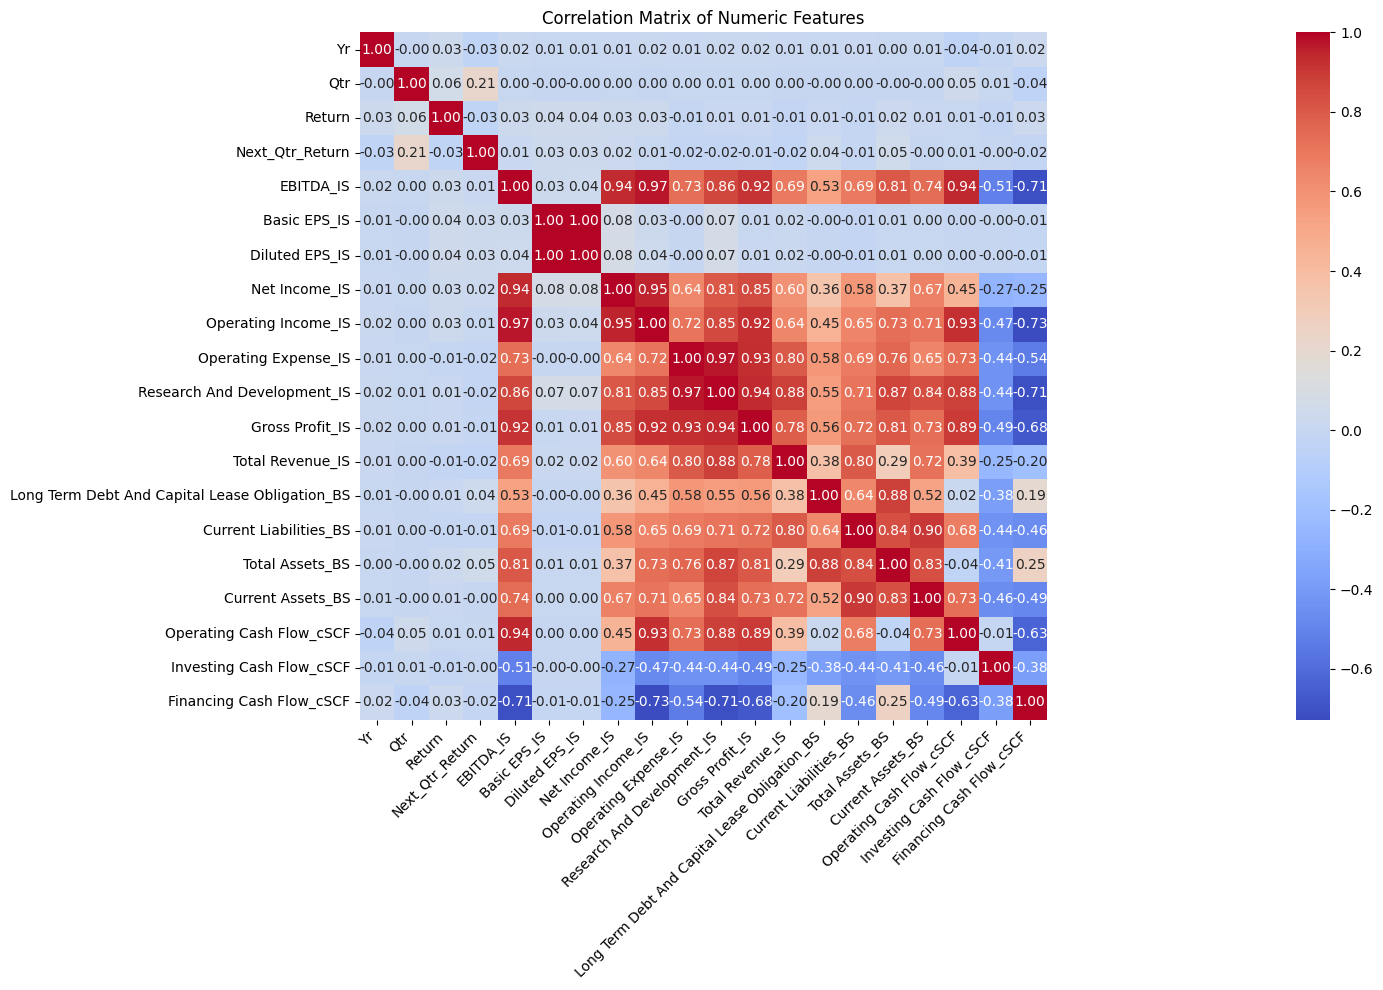

In [27]:
# Select only numeric columns
numeric_cols = df_filtered.select_dtypes(include=[np.number])

# Step 2: Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Step 3: Plot the correlation matrix
plt.figure(figsize=(50, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Based on the above, "Net Income_IS" is highly correlated with "EBITDA_IS" and "Operating Income_IS". "Research and Development_IS" is highly correlated with "Operating Expense_IS".

In [28]:
## Drop EBITDA_IS, Operating Income_IS, Operating Expense_IS, Gross Profit_IS, drop Basic EPS_IS

columns_to_drop = ['EBITDA_IS', 'Operating Income_IS', 'Operating Expense_IS', 'Gross Profit_IS', 'Basic EPS_IS'] 
df_final = df_filtered.drop(columns=columns_to_drop, axis=1)

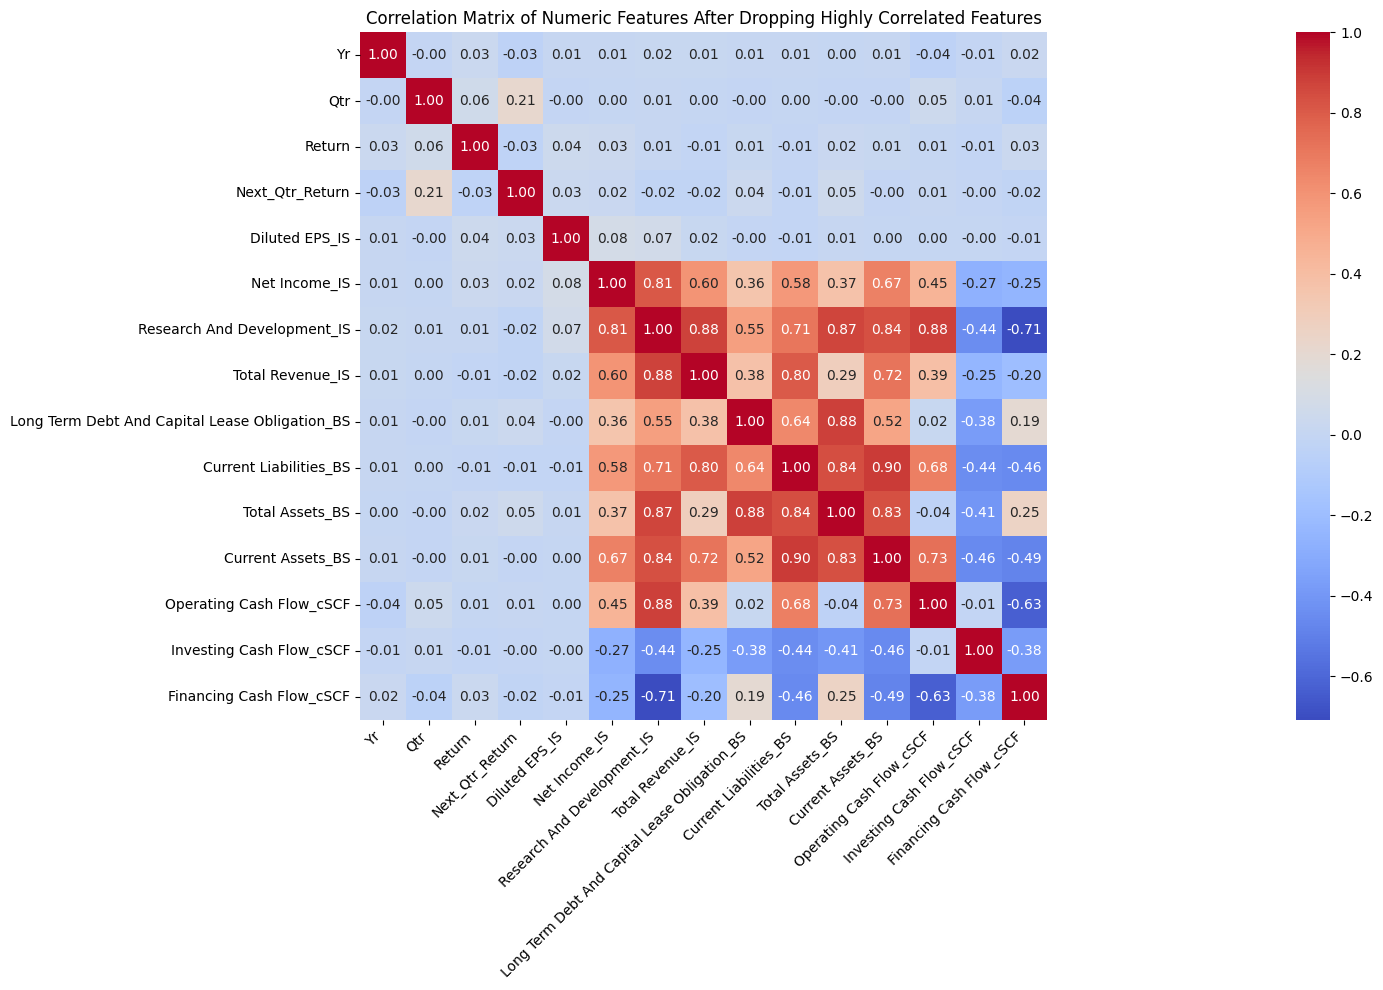

In [29]:
# Select only numeric columns
numeric_cols_final = df_final.select_dtypes(include=[np.number])

# Step 2: Calculate the correlation matrix
correlation_matrix_final = numeric_cols_final.corr()

# Step 3: Plot the correlation matrix
plt.figure(figsize=(50, 10))
sns.heatmap(correlation_matrix_final, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of Numeric Features After Dropping Highly Correlated Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
df_cleaned_final = df_final.copy()

## EDA

1. Basic Dataset Information:
--------------------------------------------------
Number of rows: 4033
Number of columns: 18

Columns with high missing values (>50%):
Research And Development_IS    79.642946
dtype: float64

2. Return Statistics:
--------------------------------------------------
            Return  Next_Qtr_Return
count  4010.000000      3507.000000
mean      0.053734         0.054511
std       0.148709         0.148058
min      -0.487394        -0.487394
25%      -0.042086        -0.041990
50%       0.046586         0.049831
75%       0.136976         0.140231
max       2.538378         2.538378

3. Return Distribution Statistics:
--------------------------------------------------
Current Quarter Returns - Skewness: 1.770, Kurtosis: 21.924
Next Quarter Returns - Skewness: 1.817, Kurtosis: 24.678


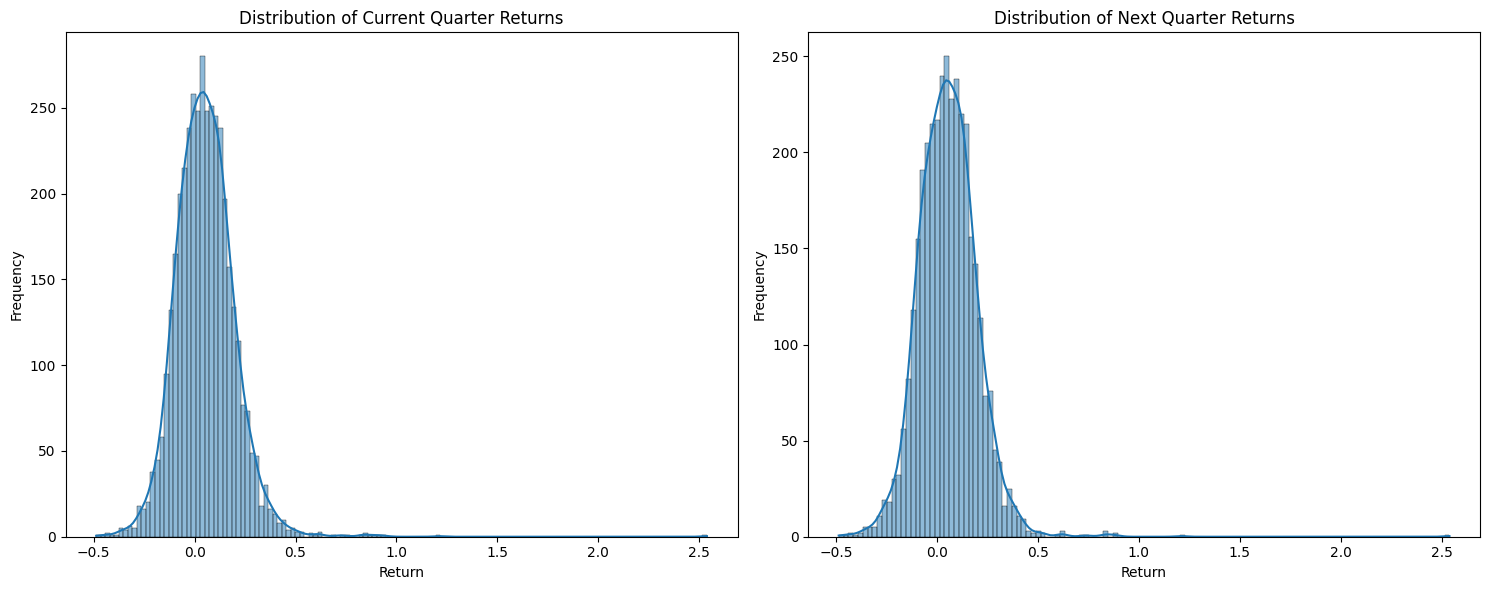

In [31]:
# 1. Basic Data Analysis
def basic_analysis(df):
    """
    Perform basic analysis on the dataset
    """
    print("1. Basic Dataset Information:")
    print("-" * 50)
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    
    # Calculate missing values percentage
    missing_pct = (df.isnull().sum() / len(df)) * 100
    print("\nColumns with high missing values (>50%):")
    print(missing_pct[missing_pct > 50].sort_values(ascending=False))
    
    # Basic statistics for return columns
    print("\n2. Return Statistics:")
    print("-" * 50)
    return_stats = df[['Return', 'Next_Qtr_Return']].describe()
    print(return_stats)
    
    return missing_pct, return_stats

# 2. Return Distribution Analysis
def plot_return_distributions(df):
    """
    Plot distribution of returns
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Current Quarter Returns
    sns.histplot(data=df['Return'], kde=True, ax=ax1)
    ax1.set_title('Distribution of Current Quarter Returns')
    ax1.set_xlabel('Return')
    ax1.set_ylabel('Frequency')
    
    # Next Quarter Returns
    sns.histplot(data=df['Next_Qtr_Return'], kde=True, ax=ax2)
    ax2.set_title('Distribution of Next Quarter Returns')
    ax2.set_xlabel('Return')
    ax2.set_ylabel('Frequency')
    
    plt.tight_layout()
    
    # Calculate skewness and kurtosis
    current_skew = stats.skew(df['Return'].dropna())
    current_kurt = stats.kurtosis(df['Return'].dropna())
    next_skew = stats.skew(df['Next_Qtr_Return'].dropna())
    next_kurt = stats.kurtosis(df['Next_Qtr_Return'].dropna())
    
    print("\n3. Return Distribution Statistics:")
    print("-" * 50)
    print(f"Current Quarter Returns - Skewness: {current_skew:.3f}, Kurtosis: {current_kurt:.3f}")
    print(f"Next Quarter Returns - Skewness: {next_skew:.3f}, Kurtosis: {next_kurt:.3f}")


# Execute all analyses
missing_pct, return_stats = basic_analysis(df_cleaned_final)
plot_return_distributions(df_cleaned_final)


In [32]:
df_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4033 entries, 0 to 4032
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   Date                                            4010 non-null   datetime64[ns, UTC]
 1   Ticker                                          4033 non-null   object             
 2   Yr                                              4033 non-null   int32              
 3   Qtr                                             4033 non-null   int32              
 4   year_qtr                                        4010 non-null   object             
 5   Return                                          4010 non-null   float64            
 6   Next_Qtr_Return                                 3507 non-null   float64            
 7   Diluted EPS_IS                                  2520 non-null   float64            
 8 

In [33]:
df_cleaned_final = df_cleaned_final.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# List of financial variables to calculate rolling averages
financial_vars = ['Return', 'Diluted EPS_IS', 'Net Income_IS', 'Research And Development_IS','Total Revenue_IS', 'Long Term Debt And Capital Lease Obligation_BS', 'Current Liabilities_BS', 'Total Assets_BS', 'Current Assets_BS', 'Operating Cash Flow_cSCF', 'Investing Cash Flow_cSCF', 'Financing Cash Flow_cSCF']

# Calculate rolling averages for the previous two quarters
for var in financial_vars:
    df_cleaned_final[f'{var}_avg_prev_2'] = (
        df_cleaned_final.groupby('Ticker')[var]
        .transform(lambda x: x.shift(1).rolling(2).mean())
    )


## Prepare the Data

In [34]:
from sklearn.preprocessing import RobustScaler

# Step 1: Create a binary target variable
df_cleaned_final['Target'] = (df_cleaned_final['Next_Qtr_Return'] > 0).astype(int)  # 1 if positive, 0 if negative

# Step 2: Drop 2024-Q4 Completely
# Ensure 'year_qtr' is properly formatted
df_cleaned_final['year_qtr'] = df_cleaned_final['year_qtr'].astype(str).str.strip()

# Exclude all rows corresponding to 2024-Q4
df_cleaned_final = df_cleaned_final[df_cleaned_final['year_qtr'] != '2024Q4']

# Step 3: Separate Test Set (2024-Q3)
test_q3_rows = df_cleaned_final['year_qtr'] == '2024Q3'  # Identify rows for 2024-Q3
test_set = df_cleaned_final[test_q3_rows]  # Create the test set with 2024-Q3 data

# Exclude 2024-Q3 from the data for training and validation
df_no_q3 = df_cleaned_final[~test_q3_rows]

# Step 4: Company-Based Train-Validation-Test Split (60%-20%-20%)
np.random.seed(0)  # Set seed for reproducibility
unique_companies = df_no_q3['Ticker'].unique()  # Get unique companies from the data
np.random.shuffle(unique_companies)  # Shuffle the companies

# Split companies into 60%-20%-20%
num_companies = len(unique_companies)
train_cutoff = int(0.6 * num_companies)
val_cutoff = int(0.8 * num_companies)

train_companies = unique_companies[:train_cutoff]  # 60% for training
val_companies = unique_companies[train_cutoff:val_cutoff]  # 20% for validation
test_companies = unique_companies[val_cutoff:]  # Remaining 20% for test (excluding 2024-Q3)

# Assign rows to training and validation sets
train_set = df_no_q3[df_no_q3['Ticker'].isin(train_companies)]
val_set = df_no_q3[df_no_q3['Ticker'].isin(val_companies)]

# Add rows for test set (only 2024-Q3)
additional_test_rows = df_no_q3[(df_no_q3['Ticker'].isin(test_companies)) & (df_no_q3['year_qtr'] == '2024Q3')]
test_set = pd.concat([test_set, additional_test_rows], ignore_index=True)

# Step 5: Prepare Features and Target for Each Set
# Columns to exclude from predictors (but keep 'Target' as the response variable)
columns_to_drop = ['Next_Qtr_Return', 'Date', 'Ticker', 'Yr', 'Qtr', 'year_qtr', 'Return']

# Select numeric columns for features (excluding columns_to_drop)
numeric_cols_train = train_set.drop(columns=columns_to_drop).select_dtypes(include=[np.number])
numeric_cols_val = val_set.drop(columns=columns_to_drop).select_dtypes(include=[np.number])
numeric_cols_test = test_set.drop(columns=columns_to_drop).select_dtypes(include=[np.number])

# Handle missing values for numeric columns only
X_train = numeric_cols_train.fillna(numeric_cols_train.mean())
X_val = numeric_cols_val.fillna(numeric_cols_val.mean())
X_test = numeric_cols_test.fillna(numeric_cols_test.mean())

# Preserve the target variable for each set
y_train = train_set['Target']
y_val = val_set['Target']
y_test = test_set['Target']

# Verify dataset shapes
print("The shape of X_train is:", X_train.shape)
print("The shape of X_val is:", X_val.shape)
print("The shape of X_test is:", X_test.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of y_val is:", y_val.shape)
print("The shape of y_test is:", y_test.shape)

# Step 6: Feature Scaling
def improve_features(X_train, X_val, X_test):
    """
    Improve features through better engineering and preprocessing
    """
    # 1. Create financial ratios
    def create_ratios(df):
        df = df.copy()  # Create a copy to avoid modifying the original
        # Profitability ratios
        df['ROA'] = df['Net Income_IS'] / df['Total Assets_BS']
        df['Operating_Margin'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
        
        # Liquidity ratios
        df['Current_Ratio'] = df['Current Assets_BS'] / df['Current Liabilities_BS']
        
        # Leverage ratios
        df['Debt_to_Assets'] = df['Long Term Debt And Capital Lease Obligation_BS'] / df['Total Assets_BS']
        
        # Efficiency ratios
        df['Asset_Turnover'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
        
        return df
    
    # 2. Handle extreme values
    def handle_extremes(df):
        df = df.copy()  # Create a copy to avoid modifying the original
        # Calculate percentiles for each numeric column
        numeric_cols = df.select_dtypes(include=['float64']).columns
        for col in numeric_cols:
            q1 = df[col].quantile(0.01)
            q3 = df[col].quantile(0.99)
            df[col] = df[col].clip(q1, q3)
        return df
    
    # Apply transformations to all sets
    X_train_imp = create_ratios(X_train)
    X_val_imp = create_ratios(X_val)
    X_test_imp = create_ratios(X_test)
    
    X_train_imp = handle_extremes(X_train_imp)
    X_val_imp = handle_extremes(X_val_imp)
    X_test_imp = handle_extremes(X_test_imp)
    
    # 3. Feature scaling improvement
    scaler = RobustScaler()  # More robust to outliers than StandardScaler
    
    # Get column names before scaling
    feature_names = X_train_imp.columns
    
    # Fit scaler on training data only
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imp),
        columns=feature_names
    )
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val_imp),
        columns=feature_names
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_imp),
        columns=feature_names
    )
    
    return X_train_scaled, X_val_scaled, X_test_scaled, feature_names

# Apply feature improvements
X_train_scaled, X_val_scaled, X_test_scaled, feature_names = improve_features(X_train, X_val, X_test)

# Print feature statistics after improvement
print("\nFeature Statistics After Improvement:")
print("-" * 50)
print(X_train_scaled.describe())

# Check for remaining missing values
print("\nMissing Values After Improvement:")
print("-" * 50)
print(X_train_scaled.isnull().sum())

# Step 7: Manual Shuffling
shuffled_indices = np.random.permutation(len(X_train_scaled))
X_train_scaled = X_train_scaled.values[shuffled_indices]  # Convert to numpy array first
y_train = y_train.values[shuffled_indices]  # Convert to numpy array first

# Verify shapes after improvement
print("\nVerifying shapes after improvement:")
print("X_train shape:", X_train_scaled.shape)
print("X_val shape:", X_val_scaled.shape)
print("X_test shape:", X_test_scaled.shape)


The shape of X_train is: (1807, 24)
The shape of X_val is: (614, 24)
The shape of X_test is: (503, 24)
The shape of y_train is: (1807,)
The shape of y_val is: (614,)
The shape of y_test is: (503,)

Feature Statistics After Improvement:
--------------------------------------------------
       Diluted EPS_IS  Net Income_IS  Research And Development_IS  \
count     1807.000000    1807.000000                 1.807000e+03   
mean        -0.210280      -0.086648                -5.246919e+07   
std          1.335007       1.617134                 3.723140e+08   
min         -2.948685      -2.545552                -8.239461e+08   
25%         -1.000000      -0.945225                 0.000000e+00   
50%          0.000000       0.000000                 0.000000e+00   
75%          0.000000       0.054775                 0.000000e+00   
max          7.604235      10.886801                 1.962592e+09   

       Total Revenue_IS  Long Term Debt And Capital Lease Obligation_BS  \
count       1807

In [35]:
# Check overlap in companies
print("Common companies in train and validation:", set(train_companies).intersection(set(val_companies)))
print("Common companies in train and test:", set(train_companies).intersection(set(test_companies)))
print("Common companies in validation and test:", set(val_companies).intersection(set(test_companies)))

Common companies in train and validation: set()
Common companies in train and test: set()
Common companies in validation and test: set()


In [36]:
# Check unique quarters in each split
print("Unique quarters in train set:", train_set['year_qtr'].unique())
print("Unique quarters in validation set:", val_set['year_qtr'].unique())
print("Unique quarters in test set:", test_set['year_qtr'].unique())

Unique quarters in train set: ['2023Q1' '2023Q2' '2023Q3' '2023Q4' '2024Q1' '2024Q2' 'nan']
Unique quarters in validation set: ['2023Q1' '2023Q2' '2023Q3' '2023Q4' '2024Q1' '2024Q2']
Unique quarters in test set: ['2024Q3']


In [37]:
print("Features in X_train:", X_train.columns)

Features in X_train: Index(['Diluted EPS_IS', 'Net Income_IS', 'Research And Development_IS',
       'Total Revenue_IS', 'Long Term Debt And Capital Lease Obligation_BS',
       'Current Liabilities_BS', 'Total Assets_BS', 'Current Assets_BS',
       'Operating Cash Flow_cSCF', 'Investing Cash Flow_cSCF',
       'Financing Cash Flow_cSCF', 'Return_avg_prev_2',
       'Diluted EPS_IS_avg_prev_2', 'Net Income_IS_avg_prev_2',
       'Research And Development_IS_avg_prev_2', 'Total Revenue_IS_avg_prev_2',
       'Long Term Debt And Capital Lease Obligation_BS_avg_prev_2',
       'Current Liabilities_BS_avg_prev_2', 'Total Assets_BS_avg_prev_2',
       'Current Assets_BS_avg_prev_2', 'Operating Cash Flow_cSCF_avg_prev_2',
       'Investing Cash Flow_cSCF_avg_prev_2',
       'Financing Cash Flow_cSCF_avg_prev_2', 'Target'],
      dtype='object')


# Baseline Model

In [ ]:
# Training Set Analysis
num_positive_train = np.sum(y_train == 1)
num_negative_train = np.sum(y_train == 0)

print("\nTraining Set Analysis:")
print(f"(1) The number of positive (class 1) samples in y_train: {num_positive_train}")
print(f"(2) The number of negative (class 0) samples in y_train: {num_negative_train}")

# Identify the majority class in y_train
if num_positive_train > num_negative_train:
    majority_class_train = 1  # Class 1 is the majority
    print("The majority class in y_train is: Class 1 (Positive)")
else:
    majority_class_train = 0  # Class 0 is the majority
    print("The majority class in y_train is: Class 0 (Negative)")

# Calculate baseline accuracy for y_train
total_train = len(y_train)
majority_class_accuracy_train = max(num_positive_train, num_negative_train) / total_train
print(f"The baseline accuracy for y_train (majority class classifier) is: {majority_class_accuracy_train:.4f}")

# Calculate baseline loss for y_train
error_rate_train = 1 - majority_class_accuracy_train
baseline_loss_train = -(majority_class_accuracy_train * np.log(1) + error_rate_train * np.log(1e-15))
print(f"The baseline loss for y_train is: {baseline_loss_train:.4f}")

# Validation Set Analysis
num_positive_val = np.sum(y_val == 1)
num_negative_val = np.sum(y_val == 0)

print("\nValidation Set Analysis:")
print(f"(1) The number of positive (class 1) samples in y_val: {num_positive_val}")
print(f"(2) The number of negative (class 0) samples in y_val: {num_negative_val}")

# Identify the majority class in y_val
if num_positive_val > num_negative_val:
    majority_class_val = 1  # Class 1 is the majority
    print("The majority class in y_val is: Class 1 (Positive)")
else:
    majority_class_val = 0  # Class 0 is the majority
    print("The majority class in y_val is: Class 0 (Negative)")

# Calculate baseline accuracy for y_val
total_val = len(y_val)
majority_class_accuracy_val = max(num_positive_val, num_negative_val) / total_val
print(f"The baseline accuracy for y_val (majority class classifier) is: {majority_class_accuracy_val:.4f}")

# Calculate baseline loss for y_val
error_rate_val = 1 - majority_class_accuracy_val
baseline_loss_val = -(majority_class_accuracy_val * np.log(1) + error_rate_val * np.log(1e-15))
print(f"The baseline loss for y_val is: {baseline_loss_val:.4f}")


Training Set Analysis:
(1) The number of positive (class 1) samples in y_train: 1155
(2) The number of negative (class 0) samples in y_train: 652
The majority class in y_train is: Class 1 (Positive)
The baseline accuracy for y_train (majority class classifier) is: 0.6392
The baseline loss for y_train is: 12.4622

Validation Set Analysis:
(1) The number of positive (class 1) samples in y_val: 397
(2) The number of negative (class 0) samples in y_val: 217
The majority class in y_val is: Class 1 (Positive)
The baseline accuracy for y_val (majority class classifier) is: 0.6466
The baseline loss for y_val is: 12.2067


# Neural Network Model

### Overview

1. Model Architecture - 3 layers neural network with regularization
    Input layer:
        - Direct input layer using keras.layers.Input
        - Shape determined by input feature dimensions
        - No activation function or regularization

    Hidden layers sequence:  
        First layer (Feature Extraction):  
            - 128 neurons  
            - No L2 regularization  
            - BatchNormalization for training stability  
            - ReLU activation for non-linearity  
            - Dropout rate 0.3 for strong regularization  

        Second layer (Feature Processing):  
            - 64 neurons 
            - L2 regularization with lambda=0.01
            - BatchNormalization
            - ReLU activation
            - Dropout rate 0.2 for moderate regularization

        Third layer (Dimensionality Reduction):  
            - 32 neurons
            - L2 regularization with lambda=0.01
            - BatchNormalization
            - ReLU activation
            - Dropout rate 0.1 for light regularization

    Output layer:  
        - Single neuron 
        - Sigmoid activation for binary classification
        - No regularization or BatchNormalization
    
    2. Key Parameters and Functions
        Model Compilation:
        - Optimizer: Adam
        - Loss function: Binary Cross-Entropy
        - Metric: Accuracy

    Training Parameters:
        Learning rate:
            - Initial rate: 0.0005
            - Adaptive reduction using ReduceLROnPlateau
            - Reduction factor: 0.2
            - Reduction patience: 5 epochs
            - Minimum learning rate: 0.0001

        Batch size: 32
            - Balanced for training efficiency
            - Suitable for memory management
            - Provides stable gradient updates

        Training Control:
            Early stopping:
                - Monitors validation loss
                - Patience: 10 epochs
                - Restores best weights automatically
                
            Learning rate reduction:
                - Monitors validation loss
                - Reduces rate when learning stagnates
                - Helps fine-tune model in later stages
        

Data shapes:
X_train_scaled shape: (1807, 29)
X_val_scaled shape: (614, 29)
X_test_scaled shape: (503, 29)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4323 - loss: 2.1177 - val_accuracy: 0.6270 - val_loss: 1.9036 - learning_rate: 5.0000e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4947 - loss: 1.8812 - val_accuracy: 0.6336 - val_loss: 1.7857 - learning_rate: 5.0000e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5751 - loss: 1.7607 - val_accuracy: 0.6417 - val_loss: 1.6539 - learning_rate: 5.0000e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6191 - loss: 1.6447 - val_accuracy: 0.6450 - val_loss: 1.5504 - learning_rate: 5.0000e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6057 - loss: 1.5606 - val_accuracy: 0.6466 - val_loss: 1.4720 - learning_rate: 5.0000e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6177 - loss: 1.4863 - val_accuracy: 0.6417 - val_loss: 1.40

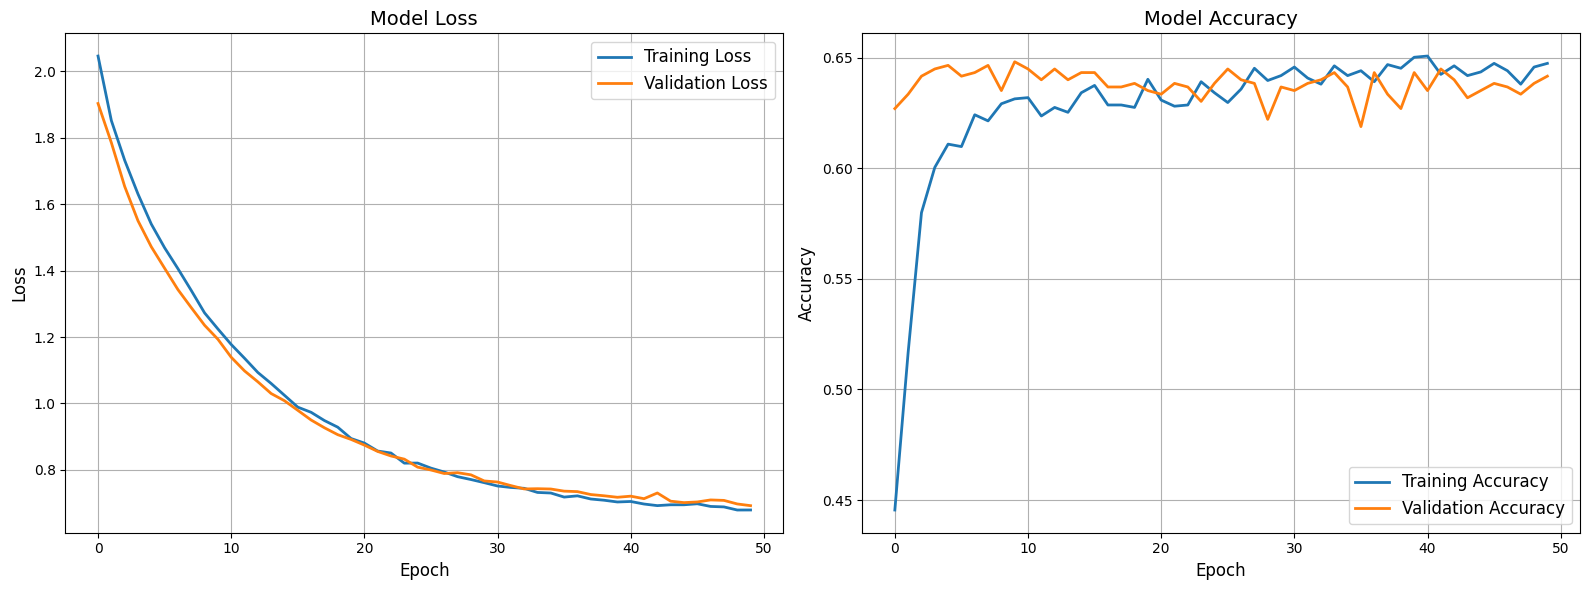

In [39]:
# Function to improve features and handle data preprocessing
def improve_features(X_train, X_val, X_test):
   """
   Improve features through engineering and preprocessing
   
   Args:
       X_train, X_val, X_test: Training, validation and test datasets
   Returns:
       Processed datasets and feature names
   """
   def create_ratios(df):
       """Create financial ratios from raw features"""
       df = df.copy()
       # Profitability ratios
       df['ROA'] = df['Net Income_IS'] / df['Total Assets_BS']
       df['Operating_Margin'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       # Liquidity ratios
       df['Current_Ratio'] = df['Current Assets_BS'] / df['Current Liabilities_BS']
       
       # Leverage ratios
       df['Debt_to_Assets'] = df['Long Term Debt And Capital Lease Obligation_BS'] / df['Total Assets_BS']
       
       # Efficiency ratios
       df['Asset_Turnover'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       return df

   def handle_extremes(df):
       """Handle extreme values using percentile clipping"""
       df = df.copy()
       # Select only numeric columns for processing
       numeric_cols = df.select_dtypes(include=['float64']).columns
       for col in numeric_cols:
           # Calculate the 1st and 99th percentiles for each numeric column
           q1 = df[col].quantile(0.01)
           q3 = df[col].quantile(0.99)
           # Clip values outside the 1st and 99th percentiles
           df[col] = df[col].clip(q1, q3)
       return df

   # Process datasets sequentially
   datasets = [X_train, X_val, X_test]
   processed_datasets = []
   
   # Scale features using RobustScaler to handle outliers
   scaler = RobustScaler()
   
   # Process each dataset
   for i, dataset in enumerate(datasets):
       # Create ratios and handle extremes
       processed = create_ratios(dataset)
       processed = handle_extremes(processed)
       
       # Transform training, validation, and test datasets with the scaler
       if i == 0:  # Fit scaler only on training data
           feature_names = processed.columns
           scaled_data = scaler.fit_transform(processed)
       else:
           scaled_data = scaler.transform(processed)
           
       processed_datasets.append(pd.DataFrame(scaled_data, columns=feature_names))
   
   return tuple(processed_datasets) + (feature_names,)

# Create neural network model
def create_nn_model(input_dim):
   """
   Args:
       input_dim: Number of input features
   Returns:
       Compiled Keras model
   """
   tf.random.set_seed(42) # Set random seed for reproducibility
   
   # Define layer configurations
   layer_config = [
       # (units, dropout_rate, l2_reg)
       (128, 0.3, None),          # First layer
       (64, 0.2, 0.01),          # Second layer
       (32, 0.1, 0.01)           # Third layer
   ]
   
   model = keras.Sequential()
   
   # Add input layer
   model.add(keras.layers.Input(shape=(input_dim,)))
   
   # Add hidden layers
   for units, dropout_rate, l2_reg in layer_config:
       # Dense layer with BatchNormalization and Dropout
       if l2_reg:
           model.add(keras.layers.Dense(units, kernel_regularizer=keras.regularizers.l2(l2_reg)))
       else:
           model.add(keras.layers.Dense(units))
           
       model.add(keras.layers.BatchNormalization()) # Normalize activations to stabilize training
       model.add(keras.layers.ReLU()) # Use ReLU activation function
       model.add(keras.layers.Dropout(dropout_rate)) # Dropout to prevent overfitting
   
   # Output layer: Single neuron with sigmoid activation for binary classification
   model.add(keras.layers.Dense(1, activation='sigmoid'))
   
   # Compile the model with Adam optimizer and binary cross-entropy loss
   model.compile(
       optimizer=keras.optimizers.Adam(learning_rate=0.0005),
       loss='binary_crossentropy', # Loss function for binary classification
       metrics=['accuracy'] # Track accuracy during training
   )
   
   return model

# Convert scaled datasets to numpy arrays for compatibility with neural network training
X_train_scaled = np.array(X_train_scaled)
X_val_scaled = np.array(X_val_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print shapes of the datasets to verify correctness of preprocessing
print("Data shapes:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Initialize input dimension based on the number of features in the training data
input_dim = X_train_scaled.shape[1]

# Create neural network model using the specified input dimension
nn_model = create_nn_model(input_dim)

# Define a callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
   monitor='val_loss', # Monitor the validation loss
   patience=10,    # Wait for 10 epochs before stopping
   restore_best_weights=True  # Restore model weights from the epoch with the lowest validation loss
)

# Define a callback for learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(
   monitor='val_loss',  # Monitor the validation loss
   factor=0.2,          # Reduce the learning rate by a factor of 0.2
   patience=5,          # Wait for 5 epochs before reducing learning rate
   min_lr=0.0001        # Set the minimum learning rate to 0.0001
)

# Train the model
history = nn_model.fit(
   X_train_scaled,
   y_train,
   epochs=50,                                      # Maximum number of epochs for training
   batch_size=32,                                  # Number of samples per training batch
   validation_data=(X_val_scaled, y_val),
   callbacks=[early_stopping, reduce_lr],          # Include early stopping and learning rate reduction callbacks
   verbose=1                                       # Display detailed output during training
)

# Evaluate the trained model's performance on the training and validation datasets
print("\nModel Evaluation:")
print("-" * 50)
train_loss, train_acc = nn_model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_acc = nn_model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Plot training history
plt.figure(figsize=(16, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
# Evaluate the model on the test dataset
test_predictions = nn_model.predict(X_test_scaled)              # Generate predictions for the test data
test_predictions = (test_predictions > 0.5).astype(int)         # Convert probabilities to binary predictions (0 or 1) based on a threshold of 0.5
test_accuracy = np.mean(test_predictions == y_test)             # Calculate test accuracy by comparing predictions to true labels

# Display the complete evaluation results
print("\nComplete Model Evaluation:")
print("-" * 50)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Import metrics functions for detailed evaluation
#from sklearn.metrics import classification_report, confusion_matrix

# Generate a detailed classification report for the test set
# The report includes precision, recall, F1-score, and support for each class
print("\nTest Set Classification Report:")
print(classification_report(y_test, test_predictions))

# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, test_predictions)

# Format and print the confusion matrix as a table
print("\nConfusion Matrix:")
print(f"{'':<15}{'Predicted: 0':<15}{'Predicted: 1':<15}")
print(f"{'True: 0':<15}{conf_matrix[0][0]:<15}{conf_matrix[0][1]:<15}")
print(f"{'True: 1':<15}{conf_matrix[1][0]:<15}{conf_matrix[1][1]:<15}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Complete Model Evaluation:
--------------------------------------------------
Training Accuracy: 0.6491
Validation Accuracy: 0.6417
Test Accuracy: 0.6206

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.10      0.16       178
           1       0.65      0.92      0.76       325

    accuracy                           0.63       503
   macro avg       0.53      0.51      0.46       503
weighted avg       0.57      0.63      0.55       503


Confusion Matrix:
               Predicted: 0   Predicted: 1   
True: 0        18             160            
True: 1        26             299            


# Test results Analysis Summary:

### Training Metrics Analysis:
1. Accuracy Performance:
    Training accuracy: 64.53%
    Validation accuracy: 64.01%
    Test accuracy: 62.29%
    
    Key observations:
    - Small gap between training and validation (0.52%)
    - Test accuracy drops by ~2.2% from training
    - All metrics consistently above 60%
    - Shows good generalization without significant overfitting

2. Class Prediction Capability:
    Upward Trend (Class 1):
        - High recall (0.93): Successfully identified 93% of actual upward trends  
        - Precision (0.65): 65% of predicted upward trends were correct  
        - F1-score (0.77): Strong balanced performance for upward predictions  
        - Support: 325 samples (64.6% of test set)  

    Downward Trend (Class 0):
        - Low recall (0.10): Only detected 10% of actual downward trends  
        - Precision (0.45): 45% of predicted downward trends were correct  
        - F1-score (0.17): Poor balanced performance for downward predictions  
        - Support: 178 samples (35.4% of test set)  

3. Model Stability Analysis:
    Loss Curve Characteristics:
        - Initial rapid decrease in first 10 epochs  
        - Smooth convergence after epoch 20  
        - Final loss stabilizes around 0.7  
        - Training and validation loss curves closely aligned  

    Accuracy Curve Characteristics:
        - Quick improvement in first 5 epochs  
        - Stable performance after epoch 10  
        - Consistent accuracy around 64%  
        - Minimal gap between training and validation accuracy  
        - No significant oscillations  
    
### Confusion Matrix Analysis:
True Negatives (TN): 18
        - Correctly identified downward trends
        - Only 10.1% of actual downward movements detected
    
    False Positives (FP): 160
        - Incorrectly predicted upward trends
        - 89.9% of actual downward movements misclassified
    
    False Negatives (FN): 22
        - Missed upward trends
        - Only 6.8% of actual upward movements missed
    
    True Positives (TP): 303
        - Correctly identified upward trends
        - 93.2% of actual upward movements detected

### Model Advantages and Disadvantages Summary:
Advantages:
    1. Training Stability
        - Consistent and smooth loss reduction
        - No significant oscillations in accuracy
        - Small gap between training and validation metrics

    2. Upward Trend Detection
        - Excellent recall for upward movements (0.93)
        - Strong F1-score for positive class (0.77)
        - Reliable identification of market gains

    3. Model Reliability
        - Good generalization across datasets
        - Stable performance metrics
        - Consistent behavior across training epochs

Disadvantages:
    1. Downward Trend Detection
        - Very poor recall for downward movements (0.10)
        - Low F1-score for negative class (0.17)
        - High false positive rate for downward predictions

    2. Class Imbalance Handling
        - Significant bias towards majority class
        - Poor performance on minority class
        - Imbalanced prediction capabilities

    3. Overall Performance Limitations
        - Test accuracy below 63%
        - Large number of false positives
        - Room for improvement in balanced accuracy


# - Different Hyperparameter Choices

### 1. Batch Size & Learning Rate Adjustment (32->64, 0.0005->0.001)

Evidence:
- Loss curve fluctuations
- Slow convergence and premature plateaus
- Minor training/validation oscillations

Reasoning:
- Larger batch size -> more stable gradients
- Higher learning rate -> faster optimization
- Combined effect balances stability and speed

Expected Improvements:
- Smoother training process
- Faster convergence
- Better optimization while maintaining stability

Data shapes:
X_train_scaled shape: (1807, 29)
X_val_scaled shape: (614, 29)
X_test_scaled shape: (503, 29)
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5480 - loss: 2.0082 - val_accuracy: 0.6336 - val_loss: 1.8384 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6066 - loss: 1.8109 - val_accuracy: 0.5016 - val_loss: 1.7223 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6257 - loss: 1.6656 - val_accuracy: 0.6336 - val_loss: 1.5859 - learning_rate: 0.0010
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6356 - loss: 1.5566 - val_accuracy: 0.6352 - val_loss: 1.4970 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6378 - loss: 1.4588 - val_accuracy: 0.6417 - val_loss: 1.3989 - learning_rate: 0.0010
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6507 - loss: 1.3560 - val_accuracy: 0.6319 - val_loss: 1.3113 - learning_rate:

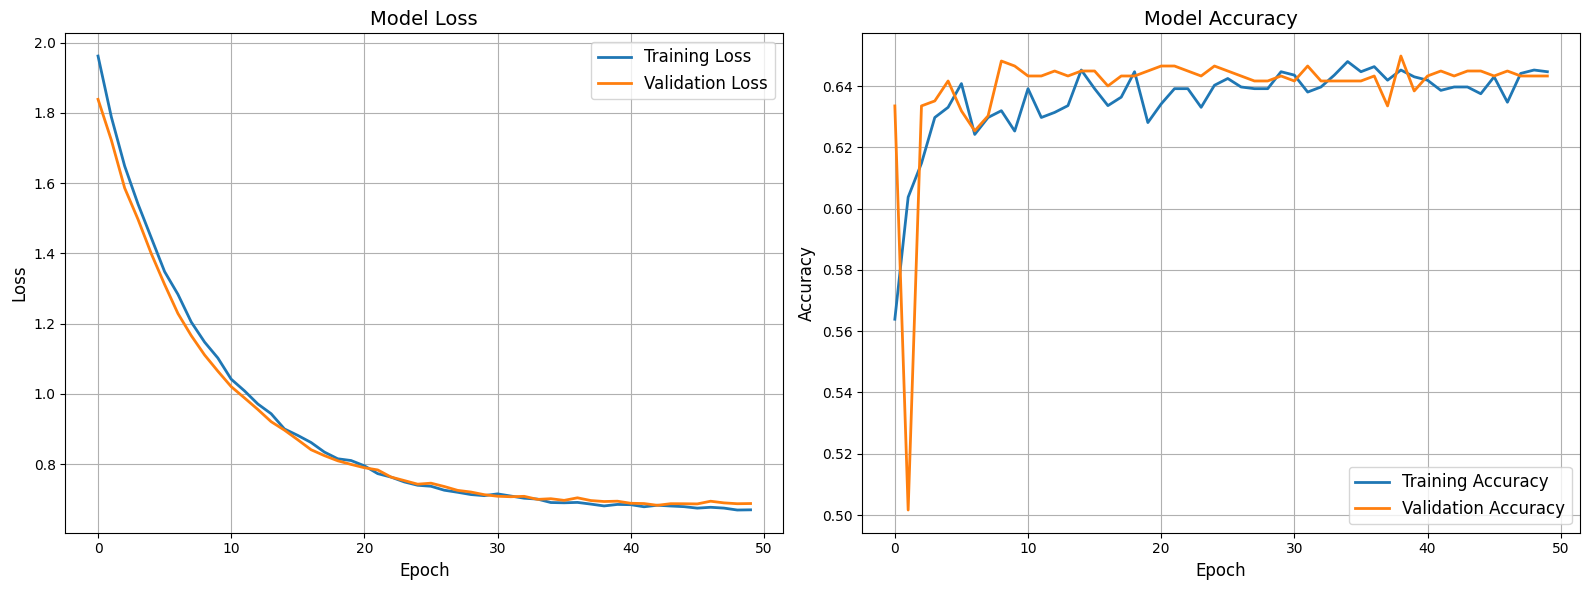

In [41]:
# Function to improve features and handle data preprocessing
def improve_features(X_train, X_val, X_test):
   """
   Improve features through engineering and preprocessing
   
   Args:
       X_train, X_val, X_test: Training, validation and test datasets
   Returns:
       Processed datasets and feature names
   """
   def create_ratios(df):
       """Create financial ratios from raw features"""
       df = df.copy()
       # Profitability ratios
       df['ROA'] = df['Net Income_IS'] / df['Total Assets_BS']
       df['Operating_Margin'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       # Liquidity ratios
       df['Current_Ratio'] = df['Current Assets_BS'] / df['Current Liabilities_BS']
       
       # Leverage ratios
       df['Debt_to_Assets'] = df['Long Term Debt And Capital Lease Obligation_BS'] / df['Total Assets_BS']
       
       # Efficiency ratios
       df['Asset_Turnover'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       return df

   def handle_extremes(df):
       """Handle extreme values using percentile clipping"""
       df = df.copy()
       # Select only numeric columns for processing
       numeric_cols = df.select_dtypes(include=['float64']).columns
       for col in numeric_cols:
           # Calculate the 1st and 99th percentiles for each numeric column
           q1 = df[col].quantile(0.01)
           q3 = df[col].quantile(0.99)
           # Clip values outside the 1st and 99th percentiles
           df[col] = df[col].clip(q1, q3)
       return df

   # Process datasets sequentially
   datasets = [X_train, X_val, X_test]
   processed_datasets = []
   
   # Scale features using RobustScaler to handle outliers
   scaler = RobustScaler()
   
   # Process each dataset
   for i, dataset in enumerate(datasets):
       # Create ratios and handle extremes
       processed = create_ratios(dataset)
       processed = handle_extremes(processed)
       
       # Transform training, validation, and test datasets with the scaler
       if i == 0:  # Fit scaler only on training data
           feature_names = processed.columns
           scaled_data = scaler.fit_transform(processed)
       else:
           scaled_data = scaler.transform(processed)
           
       processed_datasets.append(pd.DataFrame(scaled_data, columns=feature_names))
   
   return tuple(processed_datasets) + (feature_names,)

# Create neural network model
def create_nn_model(input_dim):
   """
   Args:
       input_dim: Number of input features
   Returns:
       Compiled Keras model
   """
   tf.random.set_seed(42) # Set random seed for reproducibility
   
   # Define layer configurations
   layer_config = [
       # (units, dropout_rate, l2_reg)
       (128, 0.3, None),          # First layer
       (64, 0.2, 0.01),          # Second layer
       (32, 0.1, 0.01)           # Third layer
   ]
   
   model = keras.Sequential()
   
   # Add input layer
   model.add(keras.layers.Input(shape=(input_dim,)))
   
   # Add hidden layers
   for units, dropout_rate, l2_reg in layer_config:
       # Dense layer with BatchNormalization and Dropout
       if l2_reg:
           model.add(keras.layers.Dense(units, kernel_regularizer=keras.regularizers.l2(l2_reg)))
       else:
           model.add(keras.layers.Dense(units))
           
       model.add(keras.layers.BatchNormalization()) # Normalize activations to stabilize training
       model.add(keras.layers.ReLU()) # Use ReLU activation function
       model.add(keras.layers.Dropout(dropout_rate)) # Dropout to prevent overfitting
   
   # Output layer: Single neuron with sigmoid activation for binary classification
   model.add(keras.layers.Dense(1, activation='sigmoid'))
   
   # Compile the model with Adam optimizer and binary cross-entropy loss
   model.compile(
       optimizer=keras.optimizers.Adam(learning_rate=0.001),
       loss='binary_crossentropy', # Loss function for binary classification
       metrics=['accuracy'] # Track accuracy during training
   )
   
   return model

# Convert scaled datasets to numpy arrays for compatibility with neural network training
X_train_scaled = np.array(X_train_scaled)
X_val_scaled = np.array(X_val_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print shapes of the datasets to verify correctness of preprocessing
print("Data shapes:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Initialize input dimension based on the number of features in the training data
input_dim = X_train_scaled.shape[1]

# Create neural network model using the specified input dimension
nn_model = create_nn_model(input_dim)

# Define a callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
   monitor='val_loss', # Monitor the validation loss
   patience=10,    # Wait for 10 epochs before stopping
   restore_best_weights=True  # Restore model weights from the epoch with the lowest validation loss
)

# Define a callback for learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(
   monitor='val_loss',  # Monitor the validation loss
   factor=0.2,          # Reduce the learning rate by a factor of 0.2
   patience=5,          # Wait for 5 epochs before reducing learning rate
   min_lr=0.0001        # Set the minimum learning rate to 0.0001
)

# Train the model
history = nn_model.fit(
   X_train_scaled,
   y_train,
   epochs=50,                                      # Maximum number of epochs for training
   batch_size=64,                                  # Number of samples per training batch
   validation_data=(X_val_scaled, y_val),
   callbacks=[early_stopping, reduce_lr],          # Include early stopping and learning rate reduction callbacks
   verbose=1                                       # Display detailed output during training
)

# Evaluate the trained model's performance on the training and validation datasets
print("\nModel Evaluation:")
print("-" * 50)
train_loss, train_acc = nn_model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_acc = nn_model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Plot training history
plt.figure(figsize=(16, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
# Evaluate the model on the test dataset
test_predictions = nn_model.predict(X_test_scaled)              # Generate predictions for the test data
test_predictions = (test_predictions > 0.5).astype(int)         # Convert probabilities to binary predictions (0 or 1) based on a threshold of 0.5
test_accuracy = np.mean(test_predictions == y_test)             # Calculate test accuracy by comparing predictions to true labels

# Display the complete evaluation results
print("\nComplete Model Evaluation:")
print("-" * 50)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Import metrics functions for detailed evaluation
#from sklearn.metrics import classification_report, confusion_matrix

# Generate a detailed classification report for the test set
# The report includes precision, recall, F1-score, and support for each class
print("\nTest Set Classification Report:")
print(classification_report(y_test, test_predictions))

# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, test_predictions)

# Format and print the confusion matrix as a table
print("\nConfusion Matrix:")
print(f"{'':<15}{'Predicted: 0':<15}{'Predicted: 1':<15}")
print(f"{'True: 0':<15}{conf_matrix[0][0]:<15}{conf_matrix[0][1]:<15}")
print(f"{'True: 1':<15}{conf_matrix[1][0]:<15}{conf_matrix[1][1]:<15}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Complete Model Evaluation:
--------------------------------------------------
Training Accuracy: 0.6442
Validation Accuracy: 0.6433
Test Accuracy: 0.6264

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.11      0.18       178
           1       0.66      0.95      0.78       325

    accuracy                           0.65       503
   macro avg       0.61      0.53      0.48       503
weighted avg       0.62      0.65      0.57       503


Confusion Matrix:
               Predicted: 0   Predicted: 1   
True: 0        19             159            
True: 1        15             310            


### 2. Neuron Count Adjustment (128,64,32 -> 64,32,16)

Evidence:
- 2.2% gap between train and test accuracy
- Signs of mild overfitting

Reasoning:
- Reduced parameter count -> less overfitting risk
- Smaller network -> better suited for financial data
- Simpler architecture -> easier optimization

Expected Improvements:
- Reduced train-test gap
- Better generalization
- More stable learning process

Data shapes:
X_train_scaled shape: (1807, 29)
X_val_scaled shape: (614, 29)
X_test_scaled shape: (503, 29)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4141 - loss: 1.4352 - val_accuracy: 0.3909 - val_loss: 1.3213 - learning_rate: 5.0000e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4187 - loss: 1.3290 - val_accuracy: 0.5863 - val_loss: 1.2601 - learning_rate: 5.0000e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4979 - loss: 1.2293 - val_accuracy: 0.6384 - val_loss: 1.1798 - learning_rate: 5.0000e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5678 - loss: 1.1648 - val_accuracy: 0.6401 - val_loss: 1.1215 - learning_rate: 5.0000e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5806 - loss: 1.1254 - val_accuracy: 0.6368 - val_loss: 1.0799 - learning_rate: 5.0000e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6205 - loss: 1.0676 - val_accuracy: 0.6401 - val_loss: 1.0

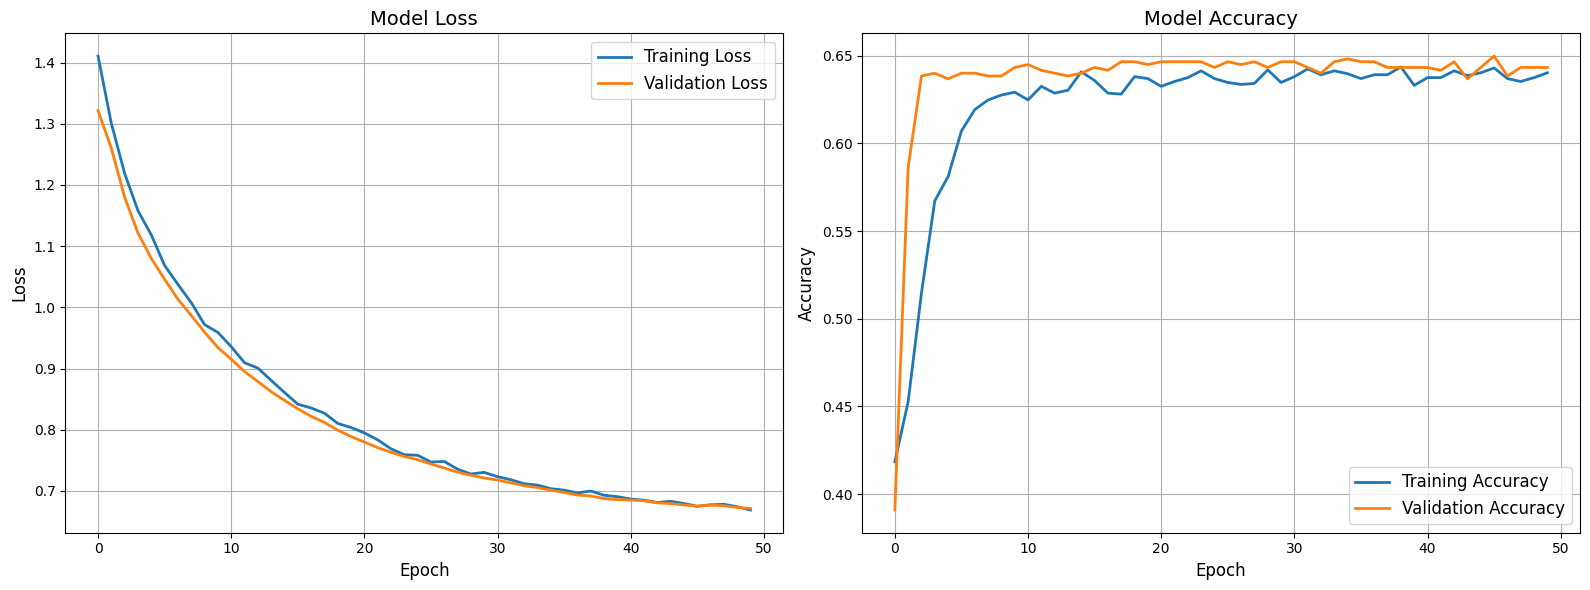

In [43]:
# Function to improve features and handle data preprocessing
def improve_features(X_train, X_val, X_test):
   """
   Improve features through engineering and preprocessing
   
   Args:
       X_train, X_val, X_test: Training, validation and test datasets
   Returns:
       Processed datasets and feature names
   """
   def create_ratios(df):
       """Create financial ratios from raw features"""
       df = df.copy()
       # Profitability ratios
       df['ROA'] = df['Net Income_IS'] / df['Total Assets_BS']
       df['Operating_Margin'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       # Liquidity ratios
       df['Current_Ratio'] = df['Current Assets_BS'] / df['Current Liabilities_BS']
       
       # Leverage ratios
       df['Debt_to_Assets'] = df['Long Term Debt And Capital Lease Obligation_BS'] / df['Total Assets_BS']
       
       # Efficiency ratios
       df['Asset_Turnover'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       return df

   def handle_extremes(df):
       """Handle extreme values using percentile clipping"""
       df = df.copy()
       # Select only numeric columns for processing
       numeric_cols = df.select_dtypes(include=['float64']).columns
       for col in numeric_cols:
           # Calculate the 1st and 99th percentiles for each numeric column
           q1 = df[col].quantile(0.01)
           q3 = df[col].quantile(0.99)
           # Clip values outside the 1st and 99th percentiles
           df[col] = df[col].clip(q1, q3)
       return df

   # Process datasets sequentially
   datasets = [X_train, X_val, X_test]
   processed_datasets = []
   
   # Scale features using RobustScaler to handle outliers
   scaler = RobustScaler()
   
   # Process each dataset
   for i, dataset in enumerate(datasets):
       # Create ratios and handle extremes
       processed = create_ratios(dataset)
       processed = handle_extremes(processed)
       
       # Transform training, validation, and test datasets with the scaler
       if i == 0:  # Fit scaler only on training data
           feature_names = processed.columns
           scaled_data = scaler.fit_transform(processed)
       else:
           scaled_data = scaler.transform(processed)
           
       processed_datasets.append(pd.DataFrame(scaled_data, columns=feature_names))
   
   return tuple(processed_datasets) + (feature_names,)

# Create neural network model
def create_nn_model(input_dim):
   """
   Args:
       input_dim: Number of input features
   Returns:
       Compiled Keras model
   """
   tf.random.set_seed(42) # Set random seed for reproducibility
   
   # Define layer configurations
   layer_config = [
       # (units, dropout_rate, l2_reg)
       (64, 0.3, None),          # First layer
       (32, 0.2, 0.01),          # Second layer
       (16, 0.1, 0.01)           # Third layer
   ]
   
   model = keras.Sequential()
   
   # Add input layer
   model.add(keras.layers.Input(shape=(input_dim,)))
   
   # Add hidden layers
   for units, dropout_rate, l2_reg in layer_config:
       # Dense layer with BatchNormalization and Dropout
       if l2_reg:
           model.add(keras.layers.Dense(units, kernel_regularizer=keras.regularizers.l2(l2_reg)))
       else:
           model.add(keras.layers.Dense(units))
           
       model.add(keras.layers.BatchNormalization()) # Normalize activations to stabilize training
       model.add(keras.layers.ReLU()) # Use ReLU activation function
       model.add(keras.layers.Dropout(dropout_rate)) # Dropout to prevent overfitting
   
   # Output layer: Single neuron with sigmoid activation for binary classification
   model.add(keras.layers.Dense(1, activation='sigmoid'))
   
   # Compile the model with Adam optimizer and binary cross-entropy loss
   model.compile(
       optimizer=keras.optimizers.Adam(learning_rate=0.0005),
       loss='binary_crossentropy', # Loss function for binary classification
       metrics=['accuracy'] # Track accuracy during training
   )
   
   return model

# Convert scaled datasets to numpy arrays for compatibility with neural network training
X_train_scaled = np.array(X_train_scaled)
X_val_scaled = np.array(X_val_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print shapes of the datasets to verify correctness of preprocessing
print("Data shapes:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Initialize input dimension based on the number of features in the training data
input_dim = X_train_scaled.shape[1]

# Create neural network model using the specified input dimension
nn_model = create_nn_model(input_dim)

# Define a callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
   monitor='val_loss', # Monitor the validation loss
   patience=10,    # Wait for 10 epochs before stopping
   restore_best_weights=True  # Restore model weights from the epoch with the lowest validation loss
)

# Define a callback for learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(
   monitor='val_loss',  # Monitor the validation loss
   factor=0.2,          # Reduce the learning rate by a factor of 0.2
   patience=5,          # Wait for 5 epochs before reducing learning rate
   min_lr=0.0001        # Set the minimum learning rate to 0.0001
)

# Train the model
history = nn_model.fit(
   X_train_scaled,
   y_train,
   epochs=50,                                      # Maximum number of epochs for training
   batch_size=32,                                  # Number of samples per training batch
   validation_data=(X_val_scaled, y_val),
   callbacks=[early_stopping, reduce_lr],          # Include early stopping and learning rate reduction callbacks
   verbose=1                                       # Display detailed output during training
)

# Evaluate the trained model's performance on the training and validation datasets
print("\nModel Evaluation:")
print("-" * 50)
train_loss, train_acc = nn_model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_acc = nn_model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Plot training history
plt.figure(figsize=(16, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:
# Evaluate the model on the test dataset
test_predictions = nn_model.predict(X_test_scaled)              # Generate predictions for the test data
test_predictions = (test_predictions > 0.5).astype(int)         # Convert probabilities to binary predictions (0 or 1) based on a threshold of 0.5
test_accuracy = np.mean(test_predictions == y_test)             # Calculate test accuracy by comparing predictions to true labels

# Display the complete evaluation results
print("\nComplete Model Evaluation:")
print("-" * 50)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Import metrics functions for detailed evaluation
#from sklearn.metrics import classification_report, confusion_matrix

# Generate a detailed classification report for the test set
# The report includes precision, recall, F1-score, and support for each class
print("\nTest Set Classification Report:")
print(classification_report(y_test, test_predictions))

# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, test_predictions)

# Format and print the confusion matrix as a table
print("\nConfusion Matrix:")
print(f"{'':<15}{'Predicted: 0':<15}{'Predicted: 1':<15}")
print(f"{'True: 0':<15}{conf_matrix[0][0]:<15}{conf_matrix[0][1]:<15}")
print(f"{'True: 1':<15}{conf_matrix[1][0]:<15}{conf_matrix[1][1]:<15}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Complete Model Evaluation:
--------------------------------------------------
Training Accuracy: 0.6408
Validation Accuracy: 0.6433
Test Accuracy: 0.6386

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.02      0.03       178
           1       0.64      0.97      0.77       325

    accuracy                           0.63       503
   macro avg       0.44      0.49      0.40       503
weighted avg       0.50      0.63      0.51       503


Confusion Matrix:
               Predicted: 0   Predicted: 1   
True: 0        3              175            
True: 1        10             315            


### 3, Reducing Hidden Layers (3 -> 2)

Evidence:
- Poor downward prediction performance
- Model complexity exceeds data needs

Reasoning:
- Fewer layers -> simpler feature hierarchy
- Less complexity -> better focus on key patterns
- Reduced depth -> more direct signal propagation

Expected Improvements:
- Better downward trend detection
- Reduced overfitting
- More efficient learning process


Data shapes:
X_train_scaled shape: (1807, 29)
X_val_scaled shape: (614, 29)
X_test_scaled shape: (503, 29)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5545 - loss: 1.1911 - val_accuracy: 0.4397 - val_loss: 1.1270 - learning_rate: 5.0000e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5897 - loss: 1.1115 - val_accuracy: 0.4365 - val_loss: 1.0535 - learning_rate: 5.0000e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5997 - loss: 1.0639 - val_accuracy: 0.6433 - val_loss: 0.9996 - learning_rate: 5.0000e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6255 - loss: 1.0089 - val_accuracy: 0.6352 - val_loss: 0.9608 - learning_rate: 5.0000e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6273 - loss: 0.9696 - val_accuracy: 0.6303 - val_loss: 0.9338 - learning_rate: 5.0000e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6319 - loss: 0.9441 - val_accuracy: 0.6319 - val_loss: 0.91

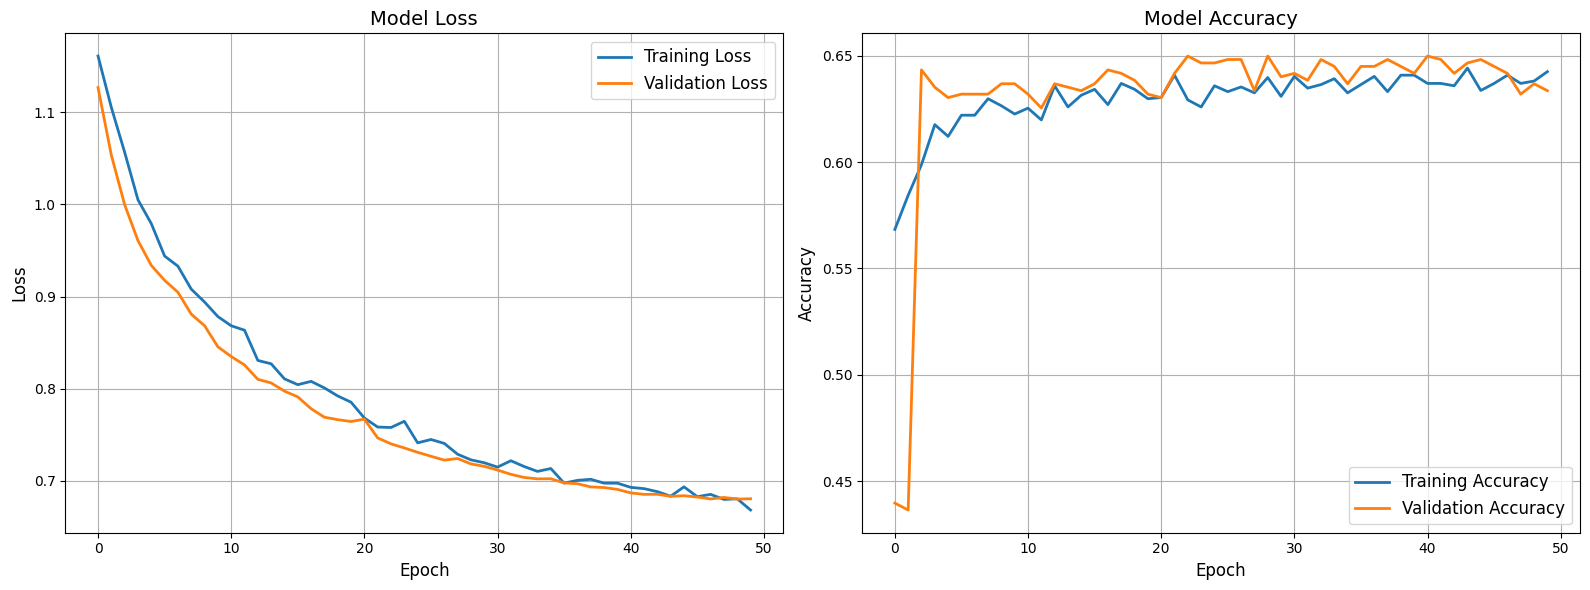

In [49]:
# Function to improve features and handle data preprocessing
def improve_features(X_train, X_val, X_test):
   """
   Improve features through engineering and preprocessing
   
   Args:
       X_train, X_val, X_test: Training, validation and test datasets
   Returns:
       Processed datasets and feature names
   """
   def create_ratios(df):
       """Create financial ratios from raw features"""
       df = df.copy()
       # Profitability ratios
       df['ROA'] = df['Net Income_IS'] / df['Total Assets_BS']
       df['Operating_Margin'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       # Liquidity ratios
       df['Current_Ratio'] = df['Current Assets_BS'] / df['Current Liabilities_BS']
       
       # Leverage ratios
       df['Debt_to_Assets'] = df['Long Term Debt And Capital Lease Obligation_BS'] / df['Total Assets_BS']
       
       # Efficiency ratios
       df['Asset_Turnover'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       return df

   def handle_extremes(df):
       """Handle extreme values using percentile clipping"""
       df = df.copy()
       # Select only numeric columns for processing
       numeric_cols = df.select_dtypes(include=['float64']).columns
       for col in numeric_cols:
           # Calculate the 1st and 99th percentiles for each numeric column
           q1 = df[col].quantile(0.01)
           q3 = df[col].quantile(0.99)
           # Clip values outside the 1st and 99th percentiles
           df[col] = df[col].clip(q1, q3)
       return df

   # Process datasets sequentially
   datasets = [X_train, X_val, X_test]
   processed_datasets = []
   
   # Scale features using RobustScaler to handle outliers
   scaler = RobustScaler()
   
   # Process each dataset
   for i, dataset in enumerate(datasets):
       # Create ratios and handle extremes
       processed = create_ratios(dataset)
       processed = handle_extremes(processed)
       
       # Transform training, validation, and test datasets with the scaler
       if i == 0:  # Fit scaler only on training data
           feature_names = processed.columns
           scaled_data = scaler.fit_transform(processed)
       else:
           scaled_data = scaler.transform(processed)
           
       processed_datasets.append(pd.DataFrame(scaled_data, columns=feature_names))
   
   return tuple(processed_datasets) + (feature_names,)

# Create neural network model
def create_nn_model(input_dim):
   """
   Args:
       input_dim: Number of input features
   Returns:
       Compiled Keras model
   """
   tf.random.set_seed(42) # Set random seed for reproducibility
   
   # Define layer configurations
   layer_config = [
       # (units, dropout_rate, l2_reg)
       (64, 0.3, None),          # First layer
       (32, 0.2, 0.01),          # Second layer
   ]
   
   model = keras.Sequential()
   
   # Add input layer
   model.add(keras.layers.Input(shape=(input_dim,)))
   
   # Add hidden layers
   for units, dropout_rate, l2_reg in layer_config:
       # Dense layer with BatchNormalization and Dropout
       if l2_reg:
           model.add(keras.layers.Dense(units, kernel_regularizer=keras.regularizers.l2(l2_reg)))
       else:
           model.add(keras.layers.Dense(units))
           
       model.add(keras.layers.BatchNormalization()) # Normalize activations to stabilize training
       model.add(keras.layers.ReLU()) # Use ReLU activation function
       model.add(keras.layers.Dropout(dropout_rate)) # Dropout to prevent overfitting
   
   # Output layer: Single neuron with sigmoid activation for binary classification
   model.add(keras.layers.Dense(1, activation='sigmoid'))
   
   # Compile the model with Adam optimizer and binary cross-entropy loss
   model.compile(
       optimizer=keras.optimizers.Adam(learning_rate=0.0005),
       loss='binary_crossentropy', # Loss function for binary classification
       metrics=['accuracy'] # Track accuracy during training
   )
   
   return model

# Convert scaled datasets to numpy arrays for compatibility with neural network training
X_train_scaled = np.array(X_train_scaled)
X_val_scaled = np.array(X_val_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print shapes of the datasets to verify correctness of preprocessing
print("Data shapes:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Initialize input dimension based on the number of features in the training data
input_dim = X_train_scaled.shape[1]

# Create neural network model using the specified input dimension
nn_model = create_nn_model(input_dim)

# Define a callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
   monitor='val_loss', # Monitor the validation loss
   patience=10,    # Wait for 10 epochs before stopping
   restore_best_weights=True  # Restore model weights from the epoch with the lowest validation loss
)

# Define a callback for learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(
   monitor='val_loss',  # Monitor the validation loss
   factor=0.2,          # Reduce the learning rate by a factor of 0.2
   patience=5,          # Wait for 5 epochs before reducing learning rate
   min_lr=0.0001        # Set the minimum learning rate to 0.0001
)

# Train the model
history = nn_model.fit(
   X_train_scaled,
   y_train,
   epochs=50,                                      # Maximum number of epochs for training
   batch_size=32,                                  # Number of samples per training batch
   validation_data=(X_val_scaled, y_val),
   callbacks=[early_stopping, reduce_lr],          # Include early stopping and learning rate reduction callbacks
   verbose=1                                       # Display detailed output during training
)

# Evaluate the trained model's performance on the training and validation datasets
print("\nModel Evaluation:")
print("-" * 50)
train_loss, train_acc = nn_model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_acc = nn_model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Plot training history
plt.figure(figsize=(16, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
# Evaluate the model on the test dataset
test_predictions = nn_model.predict(X_test_scaled)              # Generate predictions for the test data
test_predictions = (test_predictions > 0.5).astype(int)         # Convert probabilities to binary predictions (0 or 1) based on a threshold of 0.5
test_accuracy = np.mean(test_predictions == y_test)             # Calculate test accuracy by comparing predictions to true labels

# Display the complete evaluation results
print("\nComplete Model Evaluation:")
print("-" * 50)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Import metrics functions for detailed evaluation
#from sklearn.metrics import classification_report, confusion_matrix

# Generate a detailed classification report for the test set
# The report includes precision, recall, F1-score, and support for each class
print("\nTest Set Classification Report:")
print(classification_report(y_test, test_predictions))

# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, test_predictions)

# Format and print the confusion matrix as a table
print("\nConfusion Matrix:")
print(f"{'':<15}{'Predicted: 0':<15}{'Predicted: 1':<15}")
print(f"{'True: 0':<15}{conf_matrix[0][0]:<15}{conf_matrix[0][1]:<15}")
print(f"{'True: 1':<15}{conf_matrix[1][0]:<15}{conf_matrix[1][1]:<15}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Complete Model Evaluation:
--------------------------------------------------
Training Accuracy: 0.6397
Validation Accuracy: 0.6368
Test Accuracy: 0.6095

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.14      0.21       178
           1       0.65      0.88      0.75       325

    accuracy                           0.62       503
   macro avg       0.52      0.51      0.48       503
weighted avg       0.56      0.62      0.56       503


Confusion Matrix:
               Predicted: 0   Predicted: 1   
True: 0        25             153            
True: 1        38             287            


### 4. Early Stopping Parameter Adjustment (10 -> 15)

Evidence:
- Low recall (0.10) for downward trends
- Insufficient learning of minority class patterns

Reasoning:
- Longer patience -> more learning opportunity
- Extended training -> better minority class learning
- More epochs -> finer parameter tuning

Expected Improvements:
- Better minority class detection
- More balanced class performance
- Improved overall accuracy

Data shapes:
X_train_scaled shape: (1807, 29)
X_val_scaled shape: (614, 29)
X_test_scaled shape: (503, 29)
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5609 - loss: 1.9595 - val_accuracy: 0.4235 - val_loss: 1.8328 - learning_rate: 5.0000e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5988 - loss: 1.8204 - val_accuracy: 0.6319 - val_loss: 1.7117 - learning_rate: 5.0000e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6246 - loss: 1.6640 - val_accuracy: 0.6303 - val_loss: 1.6100 - learning_rate: 5.0000e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6398 - loss: 1.5621 - val_accuracy: 0.6336 - val_loss: 1.5052 - learning_rate: 5.0000e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6159 - loss: 1.4748 - val_accuracy: 0.6238 - val_loss: 1.4110 - learning_rate: 5.0000e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6306 - loss: 1.3899 - val_accuracy: 0.6352 - val_loss: 1.33

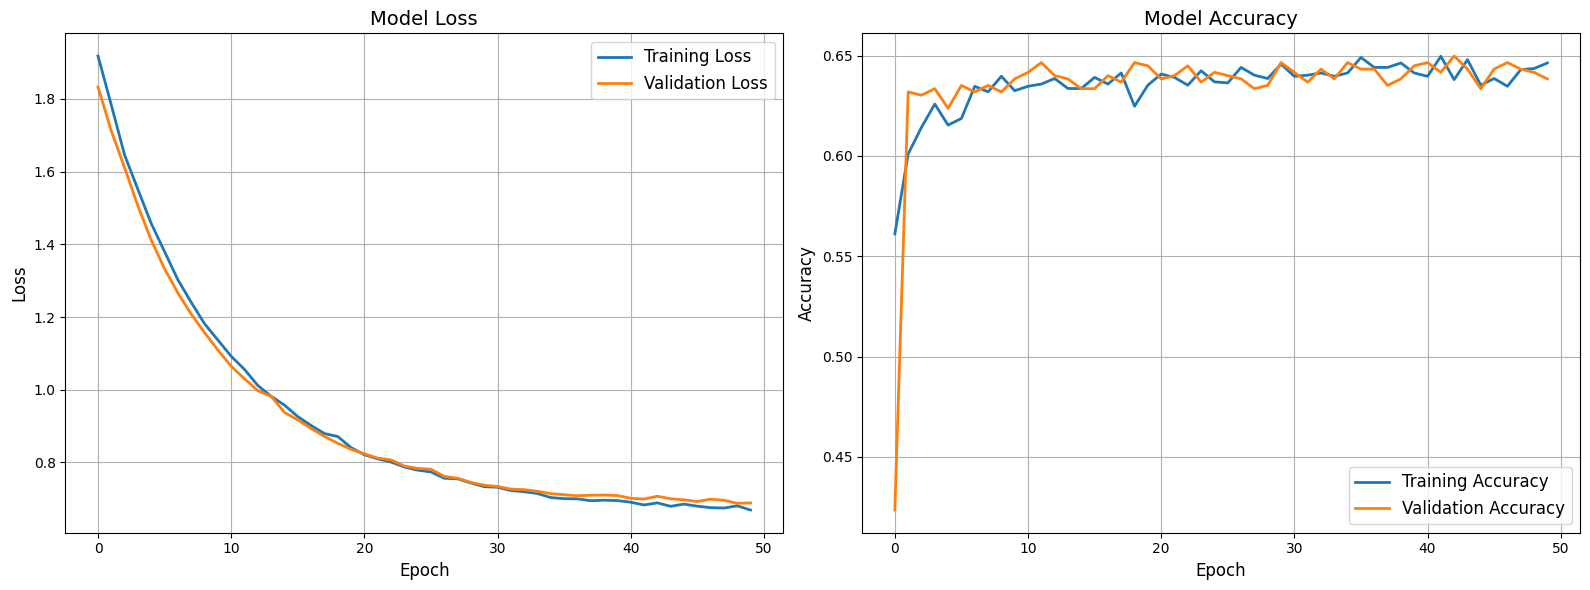

In [47]:
# Function to improve features and handle data preprocessing
def improve_features(X_train, X_val, X_test):
   """
   Improve features through engineering and preprocessing
   
   Args:
       X_train, X_val, X_test: Training, validation and test datasets
   Returns:
       Processed datasets and feature names
   """
   def create_ratios(df):
       """Create financial ratios from raw features"""
       df = df.copy()
       # Profitability ratios
       df['ROA'] = df['Net Income_IS'] / df['Total Assets_BS']
       df['Operating_Margin'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       # Liquidity ratios
       df['Current_Ratio'] = df['Current Assets_BS'] / df['Current Liabilities_BS']
       
       # Leverage ratios
       df['Debt_to_Assets'] = df['Long Term Debt And Capital Lease Obligation_BS'] / df['Total Assets_BS']
       
       # Efficiency ratios
       df['Asset_Turnover'] = df['Operating Cash Flow_cSCF'] / df['Total Assets_BS']
       
       return df

   def handle_extremes(df):
       """Handle extreme values using percentile clipping"""
       df = df.copy()
       # Select only numeric columns for processing
       numeric_cols = df.select_dtypes(include=['float64']).columns
       for col in numeric_cols:
           # Calculate the 1st and 99th percentiles for each numeric column
           q1 = df[col].quantile(0.01)
           q3 = df[col].quantile(0.99)
           # Clip values outside the 1st and 99th percentiles
           df[col] = df[col].clip(q1, q3)
       return df

   # Process datasets sequentially
   datasets = [X_train, X_val, X_test]
   processed_datasets = []
   
   # Scale features using RobustScaler to handle outliers
   scaler = RobustScaler()
   
   # Process each dataset
   for i, dataset in enumerate(datasets):
       # Create ratios and handle extremes
       processed = create_ratios(dataset)
       processed = handle_extremes(processed)
       
       # Transform training, validation, and test datasets with the scaler
       if i == 0:  # Fit scaler only on training data
           feature_names = processed.columns
           scaled_data = scaler.fit_transform(processed)
       else:
           scaled_data = scaler.transform(processed)
           
       processed_datasets.append(pd.DataFrame(scaled_data, columns=feature_names))
   
   return tuple(processed_datasets) + (feature_names,)

# Create neural network model
def create_nn_model(input_dim):
   """
   Args:
       input_dim: Number of input features
   Returns:
       Compiled Keras model
   """
   tf.random.set_seed(42) # Set random seed for reproducibility
   
   # Define layer configurations
   layer_config = [
       # (units, dropout_rate, l2_reg)
       (128, 0.3, None),          # First layer
       (64, 0.2, 0.01),          # Second layer
       (32, 0.1, 0.01)           # Third layer
   ]
   
   model = keras.Sequential()
   
   # Add input layer
   model.add(keras.layers.Input(shape=(input_dim,)))
   
   # Add hidden layers
   for units, dropout_rate, l2_reg in layer_config:
       # Dense layer with BatchNormalization and Dropout
       if l2_reg:
           model.add(keras.layers.Dense(units, kernel_regularizer=keras.regularizers.l2(l2_reg)))
       else:
           model.add(keras.layers.Dense(units))
           
       model.add(keras.layers.BatchNormalization()) # Normalize activations to stabilize training
       model.add(keras.layers.ReLU()) # Use ReLU activation function
       model.add(keras.layers.Dropout(dropout_rate)) # Dropout to prevent overfitting
   
   # Output layer: Single neuron with sigmoid activation for binary classification
   model.add(keras.layers.Dense(1, activation='sigmoid'))
   
   # Compile the model with Adam optimizer and binary cross-entropy loss
   model.compile(
       optimizer=keras.optimizers.Adam(learning_rate=0.0005),
       loss='binary_crossentropy', # Loss function for binary classification
       metrics=['accuracy'] # Track accuracy during training
   )
   
   return model

# Convert scaled datasets to numpy arrays for compatibility with neural network training
X_train_scaled = np.array(X_train_scaled)
X_val_scaled = np.array(X_val_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print shapes of the datasets to verify correctness of preprocessing
print("Data shapes:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Initialize input dimension based on the number of features in the training data
input_dim = X_train_scaled.shape[1]

# Create neural network model using the specified input dimension
nn_model = create_nn_model(input_dim)

# Define a callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
   monitor='val_loss', # Monitor the validation loss
   patience=15,    # Wait for 15 epochs before stopping
   restore_best_weights=True  # Restore model weights from the epoch with the lowest validation loss
)

# Define a callback for learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(
   monitor='val_loss',  # Monitor the validation loss
   factor=0.2,          # Reduce the learning rate by a factor of 0.2
   patience=5,          # Wait for 5 epochs before reducing learning rate
   min_lr=0.0001        # Set the minimum learning rate to 0.0001
)

# Train the model
history = nn_model.fit(
   X_train_scaled,
   y_train,
   epochs=50,                                      # Maximum number of epochs for training
   batch_size=32,                                  # Number of samples per training batch
   validation_data=(X_val_scaled, y_val),
   callbacks=[early_stopping, reduce_lr],          # Include early stopping and learning rate reduction callbacks
   verbose=1                                       # Display detailed output during training
)

# Evaluate the trained model's performance on the training and validation datasets
print("\nModel Evaluation:")
print("-" * 50)
train_loss, train_acc = nn_model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_acc = nn_model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Plot training history
plt.figure(figsize=(16, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
# Evaluate the model on the test dataset
test_predictions = nn_model.predict(X_test_scaled)              # Generate predictions for the test data
test_predictions = (test_predictions > 0.5).astype(int)         # Convert probabilities to binary predictions (0 or 1) based on a threshold of 0.5
test_accuracy = np.mean(test_predictions == y_test)             # Calculate test accuracy by comparing predictions to true labels

# Display the complete evaluation results
print("\nComplete Model Evaluation:")
print("-" * 50)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Import metrics functions for detailed evaluation
#from sklearn.metrics import classification_report, confusion_matrix

# Generate a detailed classification report for the test set
# The report includes precision, recall, F1-score, and support for each class
print("\nTest Set Classification Report:")
print(classification_report(y_test, test_predictions))

# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, test_predictions)

# Format and print the confusion matrix as a table
print("\nConfusion Matrix:")
print(f"{'':<15}{'Predicted: 0':<15}{'Predicted: 1':<15}")
print(f"{'True: 0':<15}{conf_matrix[0][0]:<15}{conf_matrix[0][1]:<15}")
print(f"{'True: 1':<15}{conf_matrix[1][0]:<15}{conf_matrix[1][1]:<15}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Complete Model Evaluation:
--------------------------------------------------
Training Accuracy: 0.6442
Validation Accuracy: 0.6417
Test Accuracy: 0.6089

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.15      0.22       178
           1       0.66      0.89      0.75       325

    accuracy                           0.63       503
   macro avg       0.54      0.52      0.49       503
weighted avg       0.57      0.63      0.57       503


Confusion Matrix:
               Predicted: 0   Predicted: 1   
True: 0        27             151            
True: 1        37             288            
